In [56]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 23.6 MB/s eta 0:00:00


In [57]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
import pandas as pd
import random
from datetime import datetime, timedelta
from catboost import CatBoostRegressor

## Session 1 : Prepare Training data

In [3]:
LocationCode = 1
site_code = '01'
Site="L1"

# 因為本次的競賽我們是在 colab 上運行，因此如果要在其他的環境上運行除了要裝載相對應的套件跟確保是否可以使用 GPU 訓練外還需要設定 training data 跟 testing data 以及 output 的路徑
url_training_data = r"/content/drive/MyDrive/Colab Notebooks/Data science competition/T-brain 2024 Sun light Power predition/Training data"
url_testing_data = '/content/drive/MyDrive/Colab Notebooks/Data science competition/T-brain 2024 Sun light Power predition/Testing data'
url_output = "/content/drive/MyDrive/Colab Notebooks/Data science competition/T-brain 2024 Sun light Power predition/Prediction_LSTM_XG_CB_pred/df_pred_LSTM_XG_boost_"

In [4]:
os.chdir(url_training_data)
print(os.getcwd())

df_raw_data_L1 = pd.read_csv(Site+"_Train.csv")
df_raw_data_L1['DateTime'] = pd.to_datetime(df_raw_data_L1['DateTime'])
df_raw_data_L1['Month'] = df_raw_data_L1['DateTime'].dt.to_period('M')
df_raw_data_L1['Date'] = df_raw_data_L1['DateTime'].dt.date
df_raw_data_L1['DateTime'] = pd.to_datetime(df_raw_data_L1['DateTime']).dt.floor('T') # 只保留到分鐘

/content/drive/MyDrive/Colab Notebooks/Data science competition/T-brain 2024 Sun light Power predition/Training data


<ipython-input-4-c938b95e05a0>:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_raw_data_L1['DateTime'] = pd.to_datetime(df_raw_data_L1['DateTime']).dt.floor('T') # 只保留到分鐘


In [5]:
# filter timestamp 8:00-16:59
df_raw_data_L1['Hour-Minute'] = df_raw_data_L1['DateTime'].dt.time
df_raw_data_L1 = df_raw_data_L1[
    (df_raw_data_L1['Hour-Minute'] >= pd.to_datetime('07:00').time()) &
    (df_raw_data_L1['Hour-Minute'] < pd.to_datetime('17:00').time())
]
df_raw_data_L1 = df_raw_data_L1.reset_index(drop=True)
df_raw_data_L1

,LocationCode,DateTime,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Month,Date,Hour-Minute
0,1,2024-01-01 07:00:00,0.0,1016.69,17.5,86.9,415.83,0.07,2024-01,2024-01-01,07:00:00
1,1,2024-01-01 07:01:00,0.0,1016.71,17.5,87.0,429.17,0.08,2024-01,2024-01-01,07:01:00
2,1,2024-01-01 07:02:00,0.0,1016.69,17.5,87.0,434.17,0.08,2024-01,2024-01-01,07:02:00
3,1,2024-01-01 07:03:00,0.0,1016.73,17.5,87.0,431.67,0.08,2024-01,2024-01-01,07:03:00
4,1,2024-01-01 07:04:00,0.0,1016.76,17.5,87.0,445.00,0.07,2024-01,2024-01-01,07:04:00
...,...,...,...,...,...,...,...,...,...,...,...
78223,1,2024-07-24 16:55:00,0.0,959.03,25.2,100.0,320.00,0.02,2024-07,2024-07-24,16:55:00
78224,1,2024-07-24 16:56:00,0.0,959.04,25.2,100.0,308.33,0.02,2024-07,2024-07-24,16:56:00
78225,1,2024-07-24 16:57:00,0.0,959.10,25.2,100.0,361.67,0.02,2024-07,2024-07-24,16:57:00
78226,1,2024-07-24 16:58:00,0.0,958.94,25.2,100.0,370.83,0.02,2024-07,2024-07-24,16:58:00


In [6]:
aggregated_df_L1 = df_raw_data_L1.groupby(['DateTime','LocationCode','Month','Date','Hour-Minute']).mean().reset_index()
aggregated_df_L1

,DateTime,LocationCode,Month,Date,Hour-Minute,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW)
0,2024-01-01 07:00:00,1,2024-01,2024-01-01,07:00:00,0.0,1016.69,17.5,86.9,415.83,0.07
1,2024-01-01 07:01:00,1,2024-01,2024-01-01,07:01:00,0.0,1016.71,17.5,87.0,429.17,0.08
2,2024-01-01 07:02:00,1,2024-01,2024-01-01,07:02:00,0.0,1016.69,17.5,87.0,434.17,0.08
3,2024-01-01 07:03:00,1,2024-01,2024-01-01,07:03:00,0.0,1016.73,17.5,87.0,431.67,0.08
4,2024-01-01 07:04:00,1,2024-01,2024-01-01,07:04:00,0.0,1016.76,17.5,87.0,445.00,0.07
...,...,...,...,...,...,...,...,...,...,...,...
78136,2024-07-24 16:55:00,1,2024-07,2024-07-24,16:55:00,0.0,959.03,25.2,100.0,320.00,0.02
78137,2024-07-24 16:56:00,1,2024-07,2024-07-24,16:56:00,0.0,959.04,25.2,100.0,308.33,0.02
78138,2024-07-24 16:57:00,1,2024-07,2024-07-24,16:57:00,0.0,959.10,25.2,100.0,361.67,0.02
78139,2024-07-24 16:58:00,1,2024-07,2024-07-24,16:58:00,0.0,958.94,25.2,100.0,370.83,0.02


In [7]:
# Check the missing date and
# 定義完整日期範圍
start_date = min(aggregated_df_L1['Date']).strftime('%Y-%m-%d')
end_date = max(aggregated_df_L1['Date']).strftime('%Y-%m-%d')
full_date_range = pd.date_range(start=start_date, end=end_date)

# 提取現有資料的日期並去重
existing_dates = pd.to_datetime(df_raw_data_L1['Date']).drop_duplicates()

# 找出完全沒有值的日期
missing_dates = full_date_range.difference(existing_dates)


# 顯示結果
print("Missing Dates:")
print("Number :",len(missing_dates))
print(missing_dates)

missing_dates = [d.date() for d in missing_dates]

Missing Dates:
Number : 35
DatetimeIndex(['2024-03-09', '2024-03-10', '2024-03-11', '2024-03-13',
               '2024-03-14', '2024-03-15', '2024-03-18', '2024-03-20',
               '2024-03-21', '2024-03-22', '2024-03-24', '2024-04-04',
               '2024-04-05', '2024-04-06', '2024-04-07', '2024-04-08',
               '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12',
               '2024-04-13', '2024-04-14', '2024-04-15', '2024-04-16',
               '2024-04-17', '2024-06-07', '2024-06-08', '2024-06-09',
               '2024-06-10', '2024-06-29', '2024-06-30', '2024-07-18',
               '2024-07-19', '2024-07-20', '2024-07-21'],
              dtype='datetime64[ns]', freq=None)


In [8]:
# Generate full time data
start_time = pd.to_datetime(min(aggregated_df_L1['Date']).strftime('%Y-%m-%d')+' 07:00:00')
end_time = pd.to_datetime(max(aggregated_df_L1['Date']).strftime('%Y-%m-%d') +' 17:00:00')
full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')
full_time_df = pd.DataFrame({'DateTime': full_time_range})
full_time_df = full_time_df[
    (full_time_df['DateTime'].dt.time >= pd.to_datetime('07:00').time()) &
    (full_time_df['DateTime'].dt.time < pd.to_datetime('17:00').time())
].reset_index(drop=True)
full_time_df

<ipython-input-8-c5070bcb5edc>:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


,DateTime
0,2024-01-01 07:00:00
1,2024-01-01 07:01:00
2,2024-01-01 07:02:00
3,2024-01-01 07:03:00
4,2024-01-01 07:04:00
...,...
123595,2024-07-24 16:55:00
123596,2024-07-24 16:56:00
123597,2024-07-24 16:57:00
123598,2024-07-24 16:58:00


In [9]:
# merge data
merged_df_L1 = pd.merge(full_time_df, aggregated_df_L1, on='DateTime', how='left')
merged_df_L1['Month'] = merged_df_L1['DateTime'].dt.to_period('M')
merged_df_L1['Date'] = merged_df_L1['DateTime'].dt.date
merged_df_L1['Hour-Minute'] = merged_df_L1['DateTime'].dt.time
merged_df_L1['LocationCode'] = LocationCode
merged_df_L1

,DateTime,LocationCode,Month,Date,Hour-Minute,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW)
0,2024-01-01 07:00:00,1,2024-01,2024-01-01,07:00:00,0.0,1016.69,17.5,86.9,415.83,0.07
1,2024-01-01 07:01:00,1,2024-01,2024-01-01,07:01:00,0.0,1016.71,17.5,87.0,429.17,0.08
2,2024-01-01 07:02:00,1,2024-01,2024-01-01,07:02:00,0.0,1016.69,17.5,87.0,434.17,0.08
3,2024-01-01 07:03:00,1,2024-01,2024-01-01,07:03:00,0.0,1016.73,17.5,87.0,431.67,0.08
4,2024-01-01 07:04:00,1,2024-01,2024-01-01,07:04:00,0.0,1016.76,17.5,87.0,445.00,0.07
...,...,...,...,...,...,...,...,...,...,...,...
123595,2024-07-24 16:55:00,1,2024-07,2024-07-24,16:55:00,0.0,959.03,25.2,100.0,320.00,0.02
123596,2024-07-24 16:56:00,1,2024-07,2024-07-24,16:56:00,0.0,959.04,25.2,100.0,308.33,0.02
123597,2024-07-24 16:57:00,1,2024-07,2024-07-24,16:57:00,0.0,959.10,25.2,100.0,361.67,0.02
123598,2024-07-24 16:58:00,1,2024-07,2024-07-24,16:58:00,0.0,958.94,25.2,100.0,370.83,0.02


In [10]:
# 創建 "10分鐘" 分組標籤
numeric_columns = ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)',
                   'Humidity(%)', 'Sunlight(Lux)', 'Power(mW)']
df_raw_data_copy = merged_df_L1.copy()
df_raw_data_copy['10min_Group'] = (df_raw_data_copy['DateTime'].dt.floor('10T'))

# 按 "10分鐘" 分組計算平均值，忽略 NA
ten_min_avg = df_raw_data_copy.groupby('10min_Group')[numeric_columns].mean().reset_index()

ten_min_avg['Date'] = ten_min_avg['10min_Group'].dt.date
ten_min_avg['Month'] = ten_min_avg['10min_Group'].dt.to_period('M')
ten_min_avg

<ipython-input-10-5ed1f31eb924>:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_raw_data_copy['10min_Group'] = (df_raw_data_copy['DateTime'].dt.floor('10T'))


,10min_Group,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Date,Month
0,2024-01-01 07:00:00,0.00000,1016.730000,17.50,86.99,470.834000,0.083000,2024-01-01,2024-01
1,2024-01-01 07:10:00,0.00000,1016.774000,17.57,86.97,659.667000,0.139000,2024-01-01,2024-01
2,2024-01-01 07:20:00,0.68193,1016.922000,17.63,86.18,889.666000,0.247000,2024-01-01,2024-01
3,2024-01-01 07:30:00,0.60737,1016.992000,17.74,85.41,1263.833000,0.447000,2024-01-01,2024-01
4,2024-01-01 07:40:00,0.00000,1017.094000,17.90,85.41,2136.833000,1.129000,2024-01-01,2024-01
...,...,...,...,...,...,...,...,...,...
12355,2024-07-24 16:10:00,0.00000,960.015000,25.13,100.00,901.084000,0.146000,2024-07-24,2024-07
12356,2024-07-24 16:20:00,0.00000,959.121000,25.10,100.00,758.085000,0.106000,2024-07-24,2024-07
12357,2024-07-24 16:30:00,0.00000,959.102000,25.10,100.00,507.167000,0.054000,2024-07-24,2024-07
12358,2024-07-24 16:40:00,0.00000,958.566667,25.10,100.00,369.998889,0.025556,2024-07-24,2024-07


## Session 2 : Prepare Testing data

In [11]:
os.chdir(url_testing_data)
df_testing = pd.read_csv('upload.csv')
df_testing

,序號,答案
0,20240117090001,NaN
1,20240117091001,NaN
2,20240117092001,NaN
3,20240117093001,NaN
4,20240117094001,NaN
...,...,...
9595,20241002161012,NaN
9596,20241002162012,NaN
9597,20241002163012,NaN
9598,20241002164012,NaN


In [12]:
df_testing_L1 = df_testing[df_testing['序號'].astype(str).str.endswith(site_code)]
df_testing_L1

,序號,答案
0,20240117090001,NaN
1,20240117091001,NaN
2,20240117092001,NaN
3,20240117093001,NaN
4,20240117094001,NaN
...,...,...
8731,20240715161001,NaN
8732,20240715162001,NaN
8733,20240715163001,NaN
8734,20240715164001,NaN


In [13]:
# predicting date
print("Number of date:",len(df_testing_L1['序號'].astype(str).str.slice(0,8).unique()))
testing_list = df_testing_L1['序號'].astype(str).str.slice(0,8).unique()
testing_list = pd.to_datetime(testing_list)
testing_list.sort_values()

Number of date: 24


DatetimeIndex(['2024-01-06', '2024-01-11', '2024-01-17', '2024-01-19',
               '2024-02-13', '2024-02-24', '2024-02-26', '2024-03-27',
               '2024-03-29', '2024-04-28', '2024-04-30', '2024-05-08',
               '2024-05-10', '2024-05-15', '2024-05-20', '2024-05-24',
               '2024-06-13', '2024-06-15', '2024-06-23', '2024-06-27',
               '2024-07-03', '2024-07-07', '2024-07-13', '2024-07-15'],
              dtype='datetime64[ns]', freq=None)

In [14]:
# 檢查所有的 testing data 是否有在 missing all date list 當中
pd.to_datetime(testing_list).isin(pd.to_datetime(missing_dates))

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

## Session 3 : Clean Training data

In [15]:
missing_power_counts_10mins = ten_min_avg.groupby('Date')['Power(mW)'].apply(lambda x: x.isnull().sum()).reset_index()
missing_power_counts_10mins.columns = ['Date', 'MissingCount']
missing_power_counts_10mins['missing_percentage'] = missing_power_counts_10mins['MissingCount']/60
print("Missing rate > 0.5 : ",sum(missing_power_counts_10mins['missing_percentage']>0.5))
missing_power_counts_10mins.sort_values(by='MissingCount',ascending=False)

Missing rate > 0.5 :  73


,Date,MissingCount,missing_percentage
202,2024-07-21,60,1.0
201,2024-07-20,60,1.0
180,2024-06-29,60,1.0
159,2024-06-08,60,1.0
158,2024-06-07,60,1.0
...,...,...,...
113,2024-04-23,0,0.0
112,2024-04-22,0,0.0
111,2024-04-21,0,0.0
109,2024-04-19,0,0.0


In [16]:
Filter_dates_list = missing_power_counts_10mins[missing_power_counts_10mins['missing_percentage']>0.5].Date
ten_min_avg_filter = ten_min_avg[~ten_min_avg['Date'].isin(Filter_dates_list)].reset_index(drop=True)
ten_min_avg_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7980 entries, 0 to 7979
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   10min_Group      7980 non-null   datetime64[ns]
 1   WindSpeed(m/s)   7537 non-null   float64       
 2   Pressure(hpa)    7537 non-null   float64       
 3   Temperature(°C)  7537 non-null   float64       
 4   Humidity(%)      7537 non-null   float64       
 5   Sunlight(Lux)    7537 non-null   float64       
 6   Power(mW)        7537 non-null   float64       
 7   Date             7980 non-null   object        
 8   Month            7980 non-null   period[M]     
dtypes: datetime64[ns](1), float64(6), object(1), period[M](1)
memory usage: 561.2+ KB


In [17]:
#補值
ten_min_avg_filter['10min_Group'] = pd.to_datetime(ten_min_avg_filter['10min_Group'])
ten_min_avg_filter = ten_min_avg_filter.set_index('10min_Group')
numeric_columns = ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)', 'Power(mW)']
ten_min_avg_filter[numeric_columns] = ten_min_avg_filter[numeric_columns].interpolate(method='time')
ten_min_avg_filter = ten_min_avg_filter.reset_index()
ten_min_avg_filter['Time'] = ten_min_avg_filter['10min_Group'].dt.time
ten_min_avg_filter

,10min_Group,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Date,Month,Time
0,2024-01-01 07:00:00,0.00000,1016.730000,17.50,86.99,470.834000,0.083000,2024-01-01,2024-01,07:00:00
1,2024-01-01 07:10:00,0.00000,1016.774000,17.57,86.97,659.667000,0.139000,2024-01-01,2024-01,07:10:00
2,2024-01-01 07:20:00,0.68193,1016.922000,17.63,86.18,889.666000,0.247000,2024-01-01,2024-01,07:20:00
3,2024-01-01 07:30:00,0.60737,1016.992000,17.74,85.41,1263.833000,0.447000,2024-01-01,2024-01,07:30:00
4,2024-01-01 07:40:00,0.00000,1017.094000,17.90,85.41,2136.833000,1.129000,2024-01-01,2024-01,07:40:00
...,...,...,...,...,...,...,...,...,...,...
7975,2024-07-24 16:10:00,0.00000,960.015000,25.13,100.00,901.084000,0.146000,2024-07-24,2024-07,16:10:00
7976,2024-07-24 16:20:00,0.00000,959.121000,25.10,100.00,758.085000,0.106000,2024-07-24,2024-07,16:20:00
7977,2024-07-24 16:30:00,0.00000,959.102000,25.10,100.00,507.167000,0.054000,2024-07-24,2024-07,16:30:00
7978,2024-07-24 16:40:00,0.00000,958.566667,25.10,100.00,369.998889,0.025556,2024-07-24,2024-07,16:40:00


In [18]:
# remove wind speed and Pressure:
ten_min_avg_filter = ten_min_avg_filter.drop(columns=['WindSpeed(m/s)','Pressure(hpa)'], errors='ignore')
ten_min_avg_filter.head(15)

,10min_Group,Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Date,Month,Time
0,2024-01-01 07:00:00,17.50,86.99,470.834,0.083,2024-01-01,2024-01,07:00:00
1,2024-01-01 07:10:00,17.57,86.97,659.667,0.139,2024-01-01,2024-01,07:10:00
2,2024-01-01 07:20:00,17.63,86.18,889.666,0.247,2024-01-01,2024-01,07:20:00
3,2024-01-01 07:30:00,17.74,85.41,1263.833,0.447,2024-01-01,2024-01,07:30:00
4,2024-01-01 07:40:00,17.90,85.41,2136.833,1.129,2024-01-01,2024-01,07:40:00
5,2024-01-01 07:50:00,18.13,85.19,2598.001,1.597,2024-01-01,2024-01,07:50:00
6,2024-01-01 08:00:00,18.29,84.38,2160.166,1.180,2024-01-01,2024-01,08:00:00
7,2024-01-01 08:10:00,18.30,83.79,2424.666,1.440,2024-01-01,2024-01,08:10:00
8,2024-01-01 08:20:00,18.28,84.88,3204.500,2.369,2024-01-01,2024-01,08:20:00
9,2024-01-01 08:30:00,18.23,85.92,4376.418,4.183,2024-01-01,2024-01,08:30:00


In [19]:
# 我們知道 sunlight 的值有上限，但這是因為設備，因此我們要排除設備因素
# 方法是建立一個 power 對 sunlight 的迴歸，然後針對那些預測值大於 max(sunlight) 的數值進行修正

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = ten_min_avg_filter[['Power(mW)']]  # 特徵，可以加其他變數
y = ten_min_avg_filter['Sunlight(Lux)']

# 訓練模型
sunlight_model = LinearRegression()
sunlight_model.fit(X, y)
r_squared = sunlight_model.score(X, y)
print("R square:",r_squared)
# 預測 Sunlight
predicted_sunlight = sunlight_model.predict(X)

# 最大值
max_sunlight = 117758
ten_min_avg_filter['Sunlight(Lux)'] = np.where(ten_min_avg_filter['Sunlight(Lux)'] > max_sunlight, predicted_sunlight, ten_min_avg_filter['Sunlight(Lux)'])


R square: 0.9138241315320956


In [20]:
from sklearn.decomposition import PCA

# 初始化空字典，用於保存每個月的 FPCA 結果
fpca_models = {}
fpca_predictions = {}  # 保存每月的所有日期的預測值
fpca_monthly_averages = {}  # 保存每月的平均預測模式
fpca_components = {}  # 保存每月的主成分數量

data_fpca = ten_min_avg_filter.copy()
data_fpca['Time'] = data_fpca['10min_Group'].dt.time

# 迭代每個月份
months = data_fpca['Month'].unique()
for month in months:
    # 1. 篩選每個月的數據
    monthly_data = data_fpca[data_fpca['Month'] == month]

    # 2. 創建以 Date 為行，Time 為列的 Power(mW) 數據表
    power_values = monthly_data.pivot_table(
        index='Date', columns='Time', values='Power(mW)', aggfunc='mean'
    )

    # 補值處理（如有必要）
    power_values_filled = power_values.fillna(method='pad', axis=1).fillna(method='bfill', axis=1)

    # 3. 構建 FPCA 模型
    pca = PCA()
    pca.fit(power_values_filled.T)
    cumulative_variance = pca.explained_variance_ratio_.cumsum()

    # 選擇解釋 95% 方差的最小成分數
    n_components = (cumulative_variance >= 0.95).argmax() + 1
    fpca_components[month] = n_components  # 保存選擇的主成分數量
    print(f"Month: {month}, Selected Components: {n_components}")

    # 使用選定的主成分數進行 FPCA
    pca = PCA(n_components=n_components)
    fpca_component = pca.fit_transform(power_values_filled.T)
    reconstructed_power = pca.inverse_transform(fpca_component)

    # 4. 保存每月的 FPCA 結果
    fpca_models[month] = pca
    fpca_predictions[month] = pd.DataFrame(
        reconstructed_power.T, columns=power_values.columns, index=power_values.index
    )

    # 5. 計算每月的平均 FPCA 預測值
    monthly_average_power = fpca_predictions[month].mean(axis=0)  # 每個時間點取平均
    fpca_monthly_averages[month] = pd.Series(
        monthly_average_power.values,
        index=power_values.columns,
        name=f"{month}_Average"
    )

Month: 2024-01, Selected Components: 6
Month: 2024-02, Selected Components: 7
Month: 2024-03, Selected Components: 6
Month: 2024-04, Selected Components: 5
Month: 2024-05, Selected Components: 9
Month: 2024-06, Selected Components: 6
Month: 2024-07, Selected Components: 4


<ipython-input-20-9ec755ffa443>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  power_values_filled = power_values.fillna(method='pad', axis=1).fillna(method='bfill', axis=1)
<ipython-input-20-9ec755ffa443>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  power_values_filled = power_values.fillna(method='pad', axis=1).fillna(method='bfill', axis=1)
<ipython-input-20-9ec755ffa443>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  power_values_filled = power_values.fillna(method='pad', axis=1).fillna(method='bfill', axis=1)
<ipython-input-20-9ec755ffa443>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  power_values_filled

In [21]:
# 將每日 FPCA 預測值合併到原始 DataFrame
daily_fpca_values = []
for month, predictions in fpca_predictions.items():
    # 將每月的預測值整理為長格式
    predictions_long = predictions.reset_index().melt(id_vars='Date', var_name='Time', value_name='FPCA_Predicted_Power')
    daily_fpca_values.append(predictions_long)

# 合併所有月份的預測值
fpca_predictions_combined = pd.concat(daily_fpca_values, ignore_index=True)
fpca_predictions_combined = fpca_predictions_combined.sort_values(by=['Date', 'Time']).reset_index(drop=True)

ten_min_avg_filter = ten_min_avg_filter.merge(
    fpca_predictions_combined,
    left_on=['Date', 'Time'],
    right_on=['Date', 'Time'],
    how='left'
)
ten_min_avg_filter.head(10)

,10min_Group,Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Date,Month,Time,FPCA_Predicted_Power
0,2024-01-01 07:00:00,17.50,86.99,470.834,0.083,2024-01-01,2024-01,07:00:00,-0.318128
1,2024-01-01 07:10:00,17.57,86.97,659.667,0.139,2024-01-01,2024-01,07:10:00,-0.035778
2,2024-01-01 07:20:00,17.63,86.18,889.666,0.247,2024-01-01,2024-01,07:20:00,0.274036
3,2024-01-01 07:30:00,17.74,85.41,1263.833,0.447,2024-01-01,2024-01,07:30:00,1.079909
4,2024-01-01 07:40:00,17.90,85.41,2136.833,1.129,2024-01-01,2024-01,07:40:00,3.340927
5,2024-01-01 07:50:00,18.13,85.19,2598.001,1.597,2024-01-01,2024-01,07:50:00,4.797483
6,2024-01-01 08:00:00,18.29,84.38,2160.166,1.180,2024-01-01,2024-01,08:00:00,4.599865
7,2024-01-01 08:10:00,18.30,83.79,2424.666,1.440,2024-01-01,2024-01,08:10:00,6.761941
8,2024-01-01 08:20:00,18.28,84.88,3204.500,2.369,2024-01-01,2024-01,08:20:00,6.996550
9,2024-01-01 08:30:00,18.23,85.92,4376.418,4.183,2024-01-01,2024-01,08:30:00,9.616920


In [22]:
# 針對每個月份的 testing data 之 FPCA 的預測值

# import testing dataset (但要記得確定是否沒有遺失值)

initial_data = ten_min_avg[
    (ten_min_avg['10min_Group'].dt.time >= pd.to_datetime("07:00:00").time()) &
    (ten_min_avg['10min_Group'].dt.time < pd.to_datetime("09:00:00").time())
]
initial_data_filter = initial_data[pd.to_datetime(initial_data['Date']).isin(pd.to_datetime(testing_list))]
initial_data_filter = initial_data_filter.drop(columns=['WindSpeed(m/s)','Pressure(hpa)'], errors='ignore').reset_index(drop=True)
initial_data_filter['Time'] = initial_data_filter['10min_Group'].dt.time

# 生成測試資料的預測值
test_predictions = []
testing_months = initial_data_filter['Month'].unique()
for month in testing_months:
    # 獲取測試月份的數據
    test_month_data = initial_data_filter[initial_data_filter['Month'] == month]

    # 獲取該月份的平均模式
    average_power = fpca_monthly_averages[month]
    # 構建測試資料的 DataFrame
    test_pred_df = pd.DataFrame(
        [average_power] * len(test_month_data['Date'].unique()),  # 每天用相同的平均模式
        columns=test_month_data['Time'].unique(),
        index=test_month_data['Date'].unique()
    ).reset_index().melt(id_vars='index', var_name='Time', value_name='FPCA_Predicted_Power')

    test_pred_df.rename(columns={'index': 'Date'}, inplace=True)
    test_predictions.append(test_pred_df)

# 合併所有測試資料的預測
test_predictions_combined = pd.concat(test_predictions, ignore_index=True)

# 合併回測試數據
initial_data_filter = initial_data_filter.merge(
    test_predictions_combined,
    left_on=['Date', 'Time'],
    right_on=['Date', 'Time'],
    how='left'
)
print(initial_data_filter.info())
initial_data_filter

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   10min_Group           288 non-null    datetime64[ns]
 1   Temperature(°C)       288 non-null    float64       
 2   Humidity(%)           288 non-null    float64       
 3   Sunlight(Lux)         288 non-null    float64       
 4   Power(mW)             288 non-null    float64       
 5   Date                  288 non-null    object        
 6   Month                 288 non-null    period[M]     
 7   Time                  288 non-null    object        
 8   FPCA_Predicted_Power  288 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(2), period[M](1)
memory usage: 20.4+ KB
None


,10min_Group,Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Date,Month,Time,FPCA_Predicted_Power
0,2024-01-06 07:00:00,12.710000,100.00,5165.167000,17.832000,2024-01-06,2024-01,07:00:00,-5.005435
1,2024-01-06 07:10:00,14.400000,100.00,11783.332000,84.872000,2024-01-06,2024-01,07:10:00,0.400588
2,2024-01-06 07:20:00,16.560000,100.00,13277.665000,149.770000,2024-01-06,2024-01,07:20:00,9.291918
3,2024-01-06 07:30:00,18.430000,100.00,19411.251000,193.418000,2024-01-06,2024-01,07:30:00,15.544003
4,2024-01-06 07:40:00,19.400000,95.18,24100.000000,254.168000,2024-01-06,2024-01,07:40:00,41.065556
...,...,...,...,...,...,...,...,...,...
283,2024-07-15 08:10:00,47.490000,35.86,43080.976000,450.822000,2024-07-15,2024-07,08:10:00,494.271013
284,2024-07-15 08:20:00,47.650000,35.18,47251.343000,558.913000,2024-07-15,2024-07,08:20:00,513.904026
285,2024-07-15 08:30:00,47.522222,35.20,47699.446667,570.908889,2024-07-15,2024-07,08:30:00,584.284167
286,2024-07-15 08:40:00,47.490000,35.61,51864.278000,661.095000,2024-07-15,2024-07,08:40:00,547.081660


In [23]:
val_date = min(ten_min_avg_filter['Date']).strftime('%Y-%m-%d')

In [24]:
# 取出兩天的資料當作是 testing 的評估

ten_min_ave_filter_test = ten_min_avg_filter[pd.to_datetime(ten_min_avg_filter['Date']).isin(pd.to_datetime([val_date]))]
ten_min_ave_filter_train = ten_min_avg_filter[~pd.to_datetime(ten_min_avg_filter['Date']).isin(pd.to_datetime([val_date]))]

In [25]:
# normalization
from sklearn.preprocessing import MinMaxScaler

# 初始化 scaler
scaler_X = MinMaxScaler()
scaler_fpca = MinMaxScaler()
scaler_power = MinMaxScaler()

features = ['Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']

# concate all data to fit and transform (我們把所有的 data 一起 normalize 避免反轉回去的時候數值差異太大)

scaler_X.fit(pd.concat([ten_min_ave_filter_train[features],initial_data_filter[features],ten_min_ave_filter_test[features]]).reset_index(drop=True))
ten_min_ave_filter_train[features] = scaler_X.transform(ten_min_ave_filter_train[features])
ten_min_ave_filter_test[features] = scaler_X.transform(ten_min_ave_filter_test[features])
initial_data_filter_scaled = initial_data_filter.copy()
initial_data_filter_scaled[features] = scaler_X.transform(initial_data_filter[features])

# transform fpca pred

scaler_fpca.fit(pd.concat([ten_min_ave_filter_train[['FPCA_Predicted_Power']],initial_data_filter[['FPCA_Predicted_Power']],ten_min_ave_filter_test[['FPCA_Predicted_Power']]]).reset_index(drop=True))
ten_min_ave_filter_train[['FPCA_Predicted_Power']] = scaler_fpca.transform(ten_min_ave_filter_train[['FPCA_Predicted_Power']])
ten_min_ave_filter_test[['FPCA_Predicted_Power']] = scaler_fpca.transform(ten_min_ave_filter_test[['FPCA_Predicted_Power']])
initial_data_filter_scaled[['FPCA_Predicted_Power']] = scaler_fpca.transform(initial_data_filter[['FPCA_Predicted_Power']])

# transform power

scaler_power.fit(pd.concat([ten_min_ave_filter_train[['Power(mW)']],initial_data_filter[['Power(mW)']],ten_min_ave_filter_test[['Power(mW)']]]).reset_index(drop=True))
ten_min_ave_filter_train[['Power(mW)']] = scaler_power.transform(ten_min_ave_filter_train[['Power(mW)']])
ten_min_ave_filter_test[['Power(mW)']] = scaler_power.transform(ten_min_ave_filter_test[['Power(mW)']])
initial_data_filter_scaled[['Power(mW)']] = scaler_power.transform(initial_data_filter[['Power(mW)']])

<ipython-input-25-566c399156fc>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ten_min_ave_filter_train[features] = scaler_X.transform(ten_min_ave_filter_train[features])
<ipython-input-25-566c399156fc>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ten_min_ave_filter_test[features] = scaler_X.transform(ten_min_ave_filter_test[features])
<ipython-input-25-566c399156fc>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [26]:
print("Scaler X min:", scaler_X.data_min_)
print("Scaler X max:", scaler_X.data_max_)

Scaler X min: [ 10.87   19.15  186.417]
Scaler X max: [5.50100000e+01 1.52500000e+02 1.18826517e+05]


In [27]:
# 創建每個月的 FPCA prediction


# 初始化 scaled 結果保存容器
fpca_monthly_averages_scaled = []

# 針對每個月份的 FPCA 平均預測值進行處理
for month, fpca_average in fpca_monthly_averages.items():
    # 將 FPCA 平均值轉換為 DataFrame，並添加時間資訊
    time_indices = pd.date_range(start="07:00:00", end="16:50:00", freq="10min").strftime("%H:%M:%S").tolist()  # 假設時間範圍為 7:00-17:00 (10 時間點)
    month_df = pd.DataFrame({
        'Month': month,
        'Time': time_indices,
        'FPCA_Predicted_Power': fpca_average
    })

    # 添加到處理列表中
    fpca_monthly_averages_scaled.append(month_df)

# 合併所有月份的 FPCA 平均預測值
fpca_monthly_averages_scaled = pd.concat(fpca_monthly_averages_scaled, ignore_index=True)

# 對 FPCA_Predicted_Power 進行標準化
fpca_monthly_averages_scaled['FPCA_Predicted_Power_Scaled'] = scaler_fpca.transform(
    fpca_monthly_averages_scaled[['FPCA_Predicted_Power']]
)

# 查看結果
print(fpca_monthly_averages_scaled.head())

     Month      Time  FPCA_Predicted_Power  FPCA_Predicted_Power_Scaled
0  2024-01  07:00:00             -5.005435                     0.116074
1  2024-01  07:10:00              0.400588                     0.118286
2  2024-01  07:20:00              9.291918                     0.121924
3  2024-01  07:30:00             15.544003                     0.124482
4  2024-01  07:40:00             41.065556                     0.134924


In [28]:
# 加入每個月份每個時間點的平均 溫度 濕度 sunlight
average_temp_by_month_time = (
    ten_min_ave_filter_train.groupby(['Month', 'Time'])['Temperature(°C)']
    .mean()
    .reset_index()
    .rename(columns={'Temperature(°C)': 'Avg_Month_Time_Temp'})
)

average_humi_by_month_time = (
    ten_min_ave_filter_train.groupby(['Month', 'Time'])['Humidity(%)']
    .mean()
    .reset_index()
    .rename(columns={'Humidity(%)': 'Avg_Month_Time_Humi'})
)

average_sunlight_by_month_time = (
    ten_min_ave_filter_train.groupby(['Month', 'Time'])['Sunlight(Lux)']
    .mean()
    .reset_index()
    .rename(columns={'Sunlight(Lux)': 'Avg_Month_Time_Sun'})
)

average_power_by_month_time = (
    ten_min_ave_filter_train.groupby(['Month', 'Time'])['Power(mW)']
    .mean()
    .reset_index()
    .rename(columns={'Power(mW)': 'Avg_Month_Time_Power'})
)


sd_temp_by_month_time = (
    ten_min_ave_filter_train.groupby(['Month', 'Time'])['Temperature(°C)']
    .std()
    .reset_index()
    .rename(columns={'Temperature(°C)': 'Sd_Month_Time_Temp'})
)

sd_humi_by_month_time = (
    ten_min_ave_filter_train.groupby(['Month', 'Time'])['Humidity(%)']
    .std()
    .reset_index()
    .rename(columns={'Humidity(%)': 'Sd_Month_Time_Humi'})
)

sd_sunlight_by_month_time = (
    ten_min_ave_filter_train.groupby(['Month', 'Time'])['Sunlight(Lux)']
    .std()
    .reset_index()
    .rename(columns={'Sunlight(Lux)': 'Sd_Month_Time_Sun'})
)

sd_power_by_month_time = (
    ten_min_ave_filter_train.groupby(['Month', 'Time'])['Power(mW)']
    .std()
    .reset_index()
    .rename(columns={'Power(mW)': 'Sd_Month_Time_Power'})
)

ten_min_ave_filter_train = ten_min_ave_filter_train.merge(
    average_temp_by_month_time, on=['Month', 'Time'], how='left'
)

ten_min_ave_filter_train = ten_min_ave_filter_train.merge(
    average_humi_by_month_time, on=['Month', 'Time'], how='left'
)

ten_min_ave_filter_train = ten_min_ave_filter_train.merge(
    average_sunlight_by_month_time, on=['Month', 'Time'], how='left'
)

ten_min_ave_filter_train = ten_min_ave_filter_train.merge(
    sd_temp_by_month_time, on=['Month', 'Time'], how='left'
)

ten_min_ave_filter_train = ten_min_ave_filter_train.merge(
    sd_humi_by_month_time, on=['Month', 'Time'], how='left'
)

ten_min_ave_filter_train = ten_min_ave_filter_train.merge(
    sd_sunlight_by_month_time, on=['Month', 'Time'], how='left'
)

ten_min_ave_filter_train

,10min_Group,Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Date,Month,Time,FPCA_Predicted_Power,Avg_Month_Time_Temp,Avg_Month_Time_Humi,Avg_Month_Time_Sun,Sd_Month_Time_Temp,Sd_Month_Time_Humi,Sd_Month_Time_Sun
0,2024-01-02 07:00:00,0.048029,0.606299,0.035116,0.004137,2024-01-02,2024-01,07:00:00,0.126974,0.087504,0.606299,0.015351,0.046539,0.000000,0.012240
1,2024-01-02 07:10:00,0.080879,0.606299,0.066303,0.017974,2024-01-02,2024-01,07:10:00,0.137108,0.095125,0.606299,0.025716,0.046308,0.000000,0.019888
2,2024-01-02 07:20:00,0.106026,0.606299,0.072299,0.014434,2024-01-02,2024-01,07:20:00,0.152376,0.105583,0.606299,0.037793,0.048709,0.000000,0.032706
3,2024-01-02 07:30:00,0.121658,0.606299,0.126321,0.050680,2024-01-02,2024-01,07:30:00,0.169469,0.114773,0.605492,0.047990,0.053758,0.004034,0.039805
4,2024-01-02 07:40:00,0.183507,0.606299,0.214850,0.132409,2024-01-02,2024-01,07:40:00,0.220930,0.124839,0.600432,0.069790,0.059744,0.027770,0.070764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7915,2024-07-24 16:10:00,0.323063,0.606299,0.006024,0.000065,2024-07-24,2024-07,16:10:00,0.112178,0.616616,0.280425,0.118051,0.148105,0.161863,0.068657
7916,2024-07-24 16:20:00,0.322383,0.606299,0.004819,0.000045,2024-07-24,2024-07,16:20:00,0.111957,0.612474,0.281613,0.092333,0.151911,0.162045,0.053276
7917,2024-07-24 16:30:00,0.322383,0.606299,0.002704,0.000019,2024-07-24,2024-07,16:30:00,0.111505,0.597317,0.290482,0.081573,0.143176,0.157477,0.044114
7918,2024-07-24 16:40:00,0.322383,0.606299,0.001547,0.000005,2024-07-24,2024-07,16:40:00,0.111125,0.579454,0.299934,0.067284,0.130902,0.151380,0.036454


In [29]:
ten_min_ave_filter_train['10min_Group'] = pd.to_datetime(ten_min_ave_filter_train['10min_Group'])

def scale_time_to_01(times):
    # 將時間轉換為分鐘數
    times_in_minutes = times.apply(lambda t: t.hour * 60 + t.minute)
    # 定義一天中時間的最小值和最大值
    min_minutes = 7 * 60  # 7:00 對應的分鐘數
    max_minutes = 16 * 60 + 50  # 16:50 對應的分鐘數
    # 使用 Min-Max Scaling 將時間縮放到 [0, 1]
    scaled_times = (times_in_minutes - min_minutes) / (max_minutes - min_minutes)
    return scaled_times

# 初始化存放結果的列表
X1 = []  # 每組當天 12 筆資料的輸入
X2 = []  # 前一天的 FPCA_Predicted_Power 或當月份的 FPCA_Predicted_Power
X3 = []  # 接下來要預測的 24 個時間點的時間資料和 Avg_Month_Time_Power
Y = []  # 每組對應的 24 筆資料的輸出

# 遍歷每一天的數據
unique_dates = ten_min_ave_filter_train['Date'].unique()

for current_date in unique_dates:
    # 篩選出當天的數據（7:00-17:00）
    daily_data = ten_min_ave_filter_train[
        (ten_min_ave_filter_train['Date'] == current_date) &
        (ten_min_ave_filter_train['10min_Group'].dt.time.between(pd.to_datetime("07:00:00").time(), pd.to_datetime("17:00:00").time()))
    ]

    # 如果當天數據不足 14 筆（12 + 2），跳過
    if len(daily_data) < 14:
        continue

    # 嘗試獲取前一天的數據
    previous_date = pd.to_datetime(current_date) - pd.Timedelta(days=1)
    previous_day_data = ten_min_ave_filter_train[ten_min_ave_filter_train['Date'] == previous_date.strftime('%Y-%m-%d')]

    # 如果沒有前一天的數據，使用當月份的 FPCA_Predicted_Power
    if previous_day_data.empty:
        previous_fpca = fpca_monthly_averages_scaled[
            fpca_monthly_averages_scaled['Month'] == daily_data.iloc[0]['Month']
        ]['FPCA_Predicted_Power_Scaled'].values
    else:
        previous_fpca = previous_day_data['FPCA_Predicted_Power'].values

    # 使用 moving window 切分數據
    for i in range(len(daily_data) - 13):  # 確保有 12 筆作為 X1，2 筆作為 Y 和 61筆作為 X3
        # X1: 當天的前 12 筆資料
        X1_window = daily_data.iloc[i:i+12][['Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']].values

        # X2: 前一天的 FPCA_Predicted_Power 或當月份的平均 FPCA 預測值
        X2_window = previous_fpca

        # X3: 接下來要預測的 6 個時間的時間點和 3 個 AVE 跟 3 個 SD
        future_data = daily_data.iloc[i+12:i+18]  # 嘗試獲取 6 筆資料

        future_times = scale_time_to_01(future_data['Time'])
        future_avg_temp = future_data['Avg_Month_Time_Temp'].values
        future_avg_humi = future_data['Avg_Month_Time_Humi'].values
        future_avg_sun = future_data['Avg_Month_Time_Sun'].values
        future_sd_temp = future_data['Sd_Month_Time_Temp'].values
        future_sd_humi = future_data['Sd_Month_Time_Humi'].values
        future_sd_sun = future_data['Sd_Month_Time_Sun'].values
        X3_features = np.column_stack((future_times, future_avg_temp, future_avg_humi, future_avg_sun, future_sd_temp, future_sd_humi, future_sd_sun))  # (6, 7)

        # 如果資料不足 6 筆，補零
        if len(X3_features) < 6:
            padding = np.zeros((6 - len(X3_features), X3_features.shape[1]))
            X3_features = np.vstack((X3_features, padding))

        # Y: 接下來 2 筆資料的目標值
        Y_target = future_data[['Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']].iloc[0:1].values

        # 添加到結果列表
        X1.append(X1_window)
        X2.append(X2_window)
        X3.append(X3_features)
        Y.append(Y_target)

# 將結果轉換為 NumPy 陣列
X1 = np.array(X1, dtype=np.float32)  # shape: (samples, 12, features)
X2 = np.array(X2, dtype=np.float32)  # shape: (samples, 60)
X3 = np.array(X3, dtype=np.float32)  # shape: (samples, 6, 9)
Y = np.array(Y, dtype=np.float32)    # shape: (samples, 1, features)

# 打印數據形狀
print(f"X1 shape: {X1.shape}, X2 shape: {X2.shape}, X3 shape: {X3.shape}, Y shape: {Y.shape}")

X1 shape: (6204, 12, 3), X2 shape: (6204, 60), X3 shape: (6204, 6, 7), Y shape: (6204, 1, 3)


## Session 4 : Training process

In [30]:
np.random.seed(42)
torch.manual_seed(42)


# 將 X1, X2, X3 組合
# 確保 X2 的维度增加一维
X2 = np.expand_dims(X2, axis=-1)

X_combined = list(zip(X1, X2, X3))

# 訓練集和驗證集切分
train_size = int(0.95 * len(X_combined))
val_size = len(X_combined) - train_size

X_train_combined, X_val_combined = X_combined[:train_size], X_combined[train_size:]
Y_train, Y_val = Y[:train_size], Y[train_size:]

# 轉換為 Tensor
X1_train = torch.tensor([x[0] for x in X_train_combined], dtype=torch.float32)  # X1
X2_train = torch.tensor([x[1] for x in X_train_combined], dtype=torch.float32)  # X2
X3_train = torch.tensor([x[2] for x in X_train_combined], dtype=torch.float32)  # X3

X1_val = torch.tensor([x[0] for x in X_val_combined], dtype=torch.float32)  # X1
X2_val = torch.tensor([x[1] for x in X_val_combined], dtype=torch.float32)  # X2
X3_val = torch.tensor([x[2] for x in X_val_combined], dtype=torch.float32)  # X3

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)

# 創建 DataLoader
train_dataset = TensorDataset(X1_train, X2_train, X3_train, Y_train)
val_dataset = TensorDataset(X1_val, X2_val, X3_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 打印數據形狀確認
print(f"X1_train shape: {X1_train.shape}, X2_train shape: {X2_train.shape}, X3_train shape: {X3_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

X1_train shape: torch.Size([5893, 12, 3]), X2_train shape: torch.Size([5893, 60, 1]), X3_train shape: torch.Size([5893, 6, 7])
Y_train shape: torch.Size([5893, 1, 3])


<ipython-input-30-1ff226b7f28c>:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X1_train = torch.tensor([x[0] for x in X_train_combined], dtype=torch.float32)  # X1


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiInputThreeLSTMs(nn.Module):
    def __init__(self, input_dim_x1, input_dim_x2, input_dim_x3, hidden_dim_1, hidden_dim_2, output_dim):
        super(MultiInputThreeLSTMs, self).__init__()

        # 第一個 LSTM (針對 X1)
        self.lstm1_x1 = nn.LSTM(input_dim_x1, hidden_dim_1, num_layers=2, bidirectional=True, batch_first=True)
        self.lstm2_x1 = nn.LSTM(hidden_dim_1 * 2, hidden_dim_2, bidirectional=True, batch_first=True)
        self.attention_x1 = nn.Linear(hidden_dim_2 * 2, 1)

        # 第二個 LSTM (針對 X2)
        self.lstm1_x2 = nn.LSTM(input_dim_x2, hidden_dim_1, num_layers=2, bidirectional=True, batch_first=True)
        self.lstm2_x2 = nn.LSTM(hidden_dim_1 * 2, hidden_dim_2, bidirectional=True, batch_first=True)
        self.attention_x2 = nn.Linear(hidden_dim_2 * 2, 1)

        # 第三個 LSTM (針對 X3)
        self.lstm1_x3 = nn.LSTM(input_dim_x3, hidden_dim_1, num_layers=2, bidirectional=True, batch_first=True)
        self.lstm2_x3 = nn.LSTM(hidden_dim_1 * 2, hidden_dim_2, bidirectional=True, batch_first=True)
        self.attention_x3 = nn.Linear(hidden_dim_2 * 2, 1)

        # 最終融合層
        self.fc_final = nn.Linear(hidden_dim_2 * 6, output_dim * 1)  # 6 個時間點的 3 個變量

        # Dropout 層
        self.dropout = nn.Dropout(0.2)

        # Sigmoid 激活函數
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2, x3):
        # LSTM1 處理 X1
        x1, _ = self.lstm1_x1(x1)
        x1, _ = self.lstm2_x1(x1)
        attention_weights_x1 = F.softmax(self.attention_x1(x1), dim=1)
        context_vector_x1 = torch.sum(attention_weights_x1 * x1, dim=1)

        # LSTM2 處理 X2
        x2, _ = self.lstm1_x2(x2)
        x2, _ = self.lstm2_x2(x2)
        attention_weights_x2 = F.softmax(self.attention_x2(x2), dim=1)
        context_vector_x2 = torch.sum(attention_weights_x2 * x2, dim=1)

        # LSTM3 處理 X3
        x3, _ = self.lstm1_x3(x3)
        x3, _ = self.lstm2_x3(x3)
        attention_weights_x3 = F.softmax(self.attention_x3(x3), dim=1)
        context_vector_x3 = torch.sum(attention_weights_x3 * x3, dim=1)

        # 融合特徵
        combined_features = torch.cat([context_vector_x1, context_vector_x2, context_vector_x3], dim=1)
        combined_features = self.dropout(combined_features)

        # 最終輸出層
        output = self.fc_final(combined_features)
        output = self.sigmoid(output)  # 添加 Sigmoid 激活函數
        output = output.view(-1, 1, output_dim)  # 恢復為 (batch_size, 3, output_dim)
        return output

# 測試輸入數據
batch_size = 32
seq_len_x1 = 12
seq_len_x2 = 60
seq_len_x3 = 6  # 更新為 6
input_dim_x1 = 3
input_dim_x2 = 1
input_dim_x3 = 7
output_dim = 3

hidden_dim_1 = 128
hidden_dim_2 = 64

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiInputThreeLSTMs(input_dim_x1, input_dim_x2, input_dim_x3, hidden_dim_1, hidden_dim_2, output_dim).to(device)


In [32]:
# 測試輸入數據
x1 = torch.randn(batch_size, seq_len_x1, input_dim_x1).to(device)
x2 = torch.randn(batch_size, seq_len_x2, input_dim_x2).to(device)
x3 = torch.randn(batch_size, seq_len_x3, input_dim_x3).to(device)

# 測試模型
outputs = model(x1, x2, x3)
print(x1.shape, x2.shape, x3.shape)
print(f"Output shape: {outputs.shape}")  # 應為 (batch_size, 12, output_dim)

torch.Size([32, 12, 3]) torch.Size([32, 60, 1]) torch.Size([32, 6, 7])
Output shape: torch.Size([32, 1, 3])


In [33]:
# 自定義損失函數
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, inputs, targets):
        loss = (self.weights * (inputs - targets) ** 2).mean()
        return loss

class DirectionalWeightedMSELoss(nn.Module):
    def __init__(self, penalty=2):
        super(DirectionalWeightedMSELoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction='none')  # 使用 element-wise MSE
        self.penalty = penalty  # 不同方向的懲罰係數

    def forward(self, y_pred, y_true):
        # 計算每個步長的預測差異
        pred_diff = y_pred[:, 1, :] - y_pred[:, 0, :]
        true_diff = y_true[:, 1, :] - y_true[:, 0, :]

        # 判斷方向是否一致
        direction_correct = torch.sign(pred_diff) == torch.sign(true_diff)  # 布林值

        # 根據方向一致性賦予權重
        weights = torch.ones_like(direction_correct, dtype=torch.float32)  # 初始化權重為1
        weights[~direction_correct] = self.penalty  # 方向不一致時，權重為 penalty

        # 計算加權的 MSE
        mse_loss = self.mse_loss(y_pred, y_true)
        weighted_loss = (weights.unsqueeze(1) * mse_loss).mean()

        return weighted_loss

# 定義權重（例如對 res Power 給更高的權重）
# weights = torch.tensor([1.0, 1.0, 1.0]).to(device)  # 假設 res Power 權重為 2
# criterion = WeightedMSELoss(weights)

# 損失函數與優化器
#criterion = DirectionalWeightedMSELoss(penalty=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
train_loss_history = []
val_loss_history = []
train_mae_history = []
val_mae_history = []

# 定義 MAE 計算函數
def mean_absolute_error(y_pred, y_true):
    return torch.mean(torch.abs(y_pred - y_true)).item()

# 訓練過程
num_epochs = 70
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_mae = 0.0
    total_train_samples = 0
    for X1_batch, X2_batch, X3_batch, Y_batch in train_loader:
        # 將數據移動到設備
        X1_batch, X2_batch, X3_batch, Y_batch = (
            X1_batch.to(device),
            X2_batch.to(device),
            X3_batch.to(device),
            Y_batch.to(device),
        )
        # 優化器梯度歸零
        optimizer.zero_grad()

        # 模型前向傳播
        outputs = model(X1_batch, X2_batch, X3_batch)

        # 計算損失
        loss = criterion(outputs, Y_batch)

        # 反向傳播與參數更新
        loss.backward()

        # 梯度裁剪（可選）
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # 累加損失和 MAE
        batch_size = Y_batch.size(0)
        train_loss += loss.item() * batch_size  # 按樣本數累計損失
        train_mae += mean_absolute_error(outputs, Y_batch) * batch_size
        total_train_samples += batch_size

    # 計算平均 Loss 和 MAE
    train_loss /= total_train_samples
    train_mae /= total_train_samples

    # 驗證
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    total_val_samples = 0
    with torch.no_grad():
        for X1_batch, X2_batch, X3_batch, Y_batch in val_loader:
            # 將數據移動到設備
            X1_batch, X2_batch, X3_batch, Y_batch = (
                X1_batch.to(device),
                X2_batch.to(device),
                X3_batch.to(device),
                Y_batch.to(device),
            )
            # 模型前向傳播
            outputs = model(X1_batch, X2_batch, X3_batch)

            # 計算損失
            loss = criterion(outputs, Y_batch)

            # 累加損失和 MAE
            batch_size = Y_batch.size(0)
            val_loss += loss.item() * batch_size
            val_mae += mean_absolute_error(outputs, Y_batch) * batch_size
            total_val_samples += batch_size

    # 計算平均 Loss 和 MAE
    val_loss /= total_val_samples
    val_mae /= total_val_samples

    # 保存到歷史記錄
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_mae_history.append(train_mae)
    val_mae_history.append(val_mae)

    # 打印當前 epoch 的結果
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}")

# 訓練結束
print("Training complete.")

Epoch 1/70, Train Loss: 0.0214, Val Loss: 0.0066, Train MAE: 0.1060, Val MAE: 0.0607
Epoch 2/70, Train Loss: 0.0062, Val Loss: 0.0043, Train MAE: 0.0555, Val MAE: 0.0479
Epoch 3/70, Train Loss: 0.0054, Val Loss: 0.0037, Train MAE: 0.0516, Val MAE: 0.0417
Epoch 4/70, Train Loss: 0.0045, Val Loss: 0.0038, Train MAE: 0.0456, Val MAE: 0.0437
Epoch 5/70, Train Loss: 0.0042, Val Loss: 0.0028, Train MAE: 0.0437, Val MAE: 0.0350
Epoch 6/70, Train Loss: 0.0038, Val Loss: 0.0027, Train MAE: 0.0401, Val MAE: 0.0383
Epoch 7/70, Train Loss: 0.0035, Val Loss: 0.0022, Train MAE: 0.0385, Val MAE: 0.0296
Epoch 8/70, Train Loss: 0.0032, Val Loss: 0.0029, Train MAE: 0.0350, Val MAE: 0.0359
Epoch 9/70, Train Loss: 0.0032, Val Loss: 0.0022, Train MAE: 0.0350, Val MAE: 0.0292
Epoch 10/70, Train Loss: 0.0030, Val Loss: 0.0024, Train MAE: 0.0329, Val MAE: 0.0326
Epoch 11/70, Train Loss: 0.0029, Val Loss: 0.0018, Train MAE: 0.0325, Val MAE: 0.0263
Epoch 12/70, Train Loss: 0.0029, Val Loss: 0.0017, Train MAE: 0

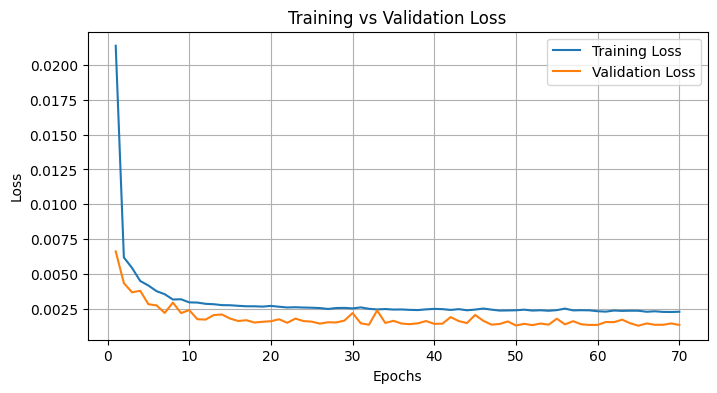

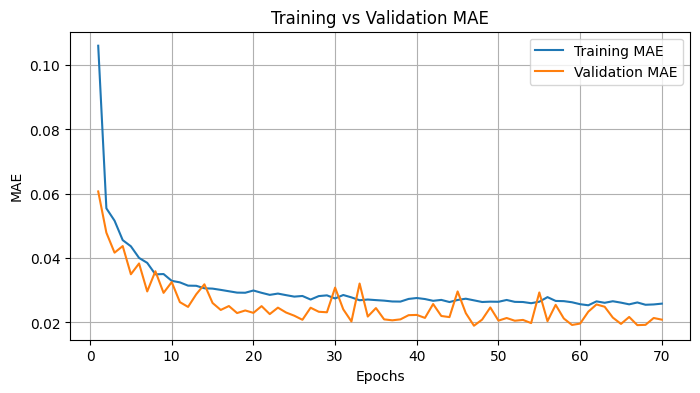

In [35]:
import matplotlib.pyplot as plt

# 繪製 Loss 和 MAE 的趨勢圖
def plot_metrics(train_loss, val_loss, train_mae, val_mae):
    epochs = range(1, len(train_loss) + 1)

    # Loss 曲線
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, train_loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    # MAE 曲線
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, train_mae, label="Training MAE")
    plt.plot(epochs, val_mae, label="Validation MAE")
    plt.title("Training vs Validation MAE")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid()
    plt.show()

# 調用函數繪製圖表
plot_metrics(train_loss_history, val_loss_history, train_mae_history, val_mae_history)

In [36]:
import numpy as np

# 隨機抽樣索引
val_sample_idx = random.randint(0, len(X_val_combined) - 1)
train_sample_idx = random.randint(0, len(X_train_combined) - 1)

# 將選取的樣本轉為張量
val_sample_X1 = torch.tensor(X_val_combined[val_sample_idx][0], dtype=torch.float32).unsqueeze(0).to(device)  # X1
val_sample_X2 = torch.tensor(X_val_combined[val_sample_idx][1], dtype=torch.float32).unsqueeze(0).to(device)  # X2
val_sample_X3 = torch.tensor(X_val_combined[val_sample_idx][2], dtype=torch.float32).unsqueeze(0).to(device)  # X3

train_sample_X1 = torch.tensor(X_train_combined[train_sample_idx][0], dtype=torch.float32).unsqueeze(0).to(device)  # X1
train_sample_X2 = torch.tensor(X_train_combined[train_sample_idx][1], dtype=torch.float32).unsqueeze(0).to(device)  # X2
train_sample_X3 = torch.tensor(X_train_combined[train_sample_idx][2], dtype=torch.float32).unsqueeze(0).to(device)  # X3

# 真值
val_sample_Y_true = torch.tensor(Y_val[val_sample_idx], dtype=torch.float32).to(device).cpu().numpy()  # Shape: (24, 4)
train_sample_Y_true = torch.tensor(Y_train[train_sample_idx], dtype=torch.float32).to(device).cpu().numpy()  # Shape: (24, 4)

# 將真值逐行反標準化
Y_val_true_original = scaler_X.inverse_transform(val_sample_Y_true)  # Shape: (24, 4)
Y_train_true_original = scaler_X.inverse_transform(train_sample_Y_true)  # Shape: (24, 4)

# 模型預測
model.eval()
val_sample_Y_pred = model(val_sample_X1, val_sample_X2, val_sample_X3).cpu().detach().numpy()  # Shape: (1, 24, 4)
train_sample_Y_pred = model(train_sample_X1, train_sample_X2, train_sample_X3).cpu().detach().numpy()  # Shape: (1, 24, 4)

# 去掉 batch 維度後反標準化
val_sample_Y_pred = val_sample_Y_pred.squeeze(0)  # Shape: (24, 4)
train_sample_Y_pred = train_sample_Y_pred.squeeze(0)  # Shape: (24, 4)

Y_val_pred_original = scaler_X.inverse_transform(val_sample_Y_pred)  # Shape: (24, 4)
Y_train_pred_original = scaler_X.inverse_transform(train_sample_Y_pred)  # Shape: (24, 4)

# 輸出結果
val_sample_result = {
    "True Value": Y_val_true_original.tolist(),
    "Predicted Value": Y_val_pred_original.tolist(),
}
train_sample_result = {
    "True Value": Y_train_true_original.tolist(),
    "Predicted Value": Y_train_pred_original.tolist(),
}

print("Validation Sample Result:", val_sample_result)
print("Training Sample Result:", train_sample_result)

Validation Sample Result: {'True Value': [[40.13999938964844, 48.65999984741211, 12480.001953125]], 'Predicted Value': [[39.4504508972168, 51.744327545166016, 14748.3857421875]]}
Training Sample Result: {'True Value': [[19.85714340209961, 100.00285339355469, 6374.404296875]], 'Predicted Value': [[19.99839210510254, 97.83455657958984, 6687.8212890625]]}


<ipython-input-36-95e9c88102f2>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_sample_Y_true = torch.tensor(Y_val[val_sample_idx], dtype=torch.float32).to(device).cpu().numpy()  # Shape: (24, 4)
<ipython-input-36-95e9c88102f2>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_sample_Y_true = torch.tensor(Y_train[train_sample_idx], dtype=torch.float32).to(device).cpu().numpy()  # Shape: (24, 4)


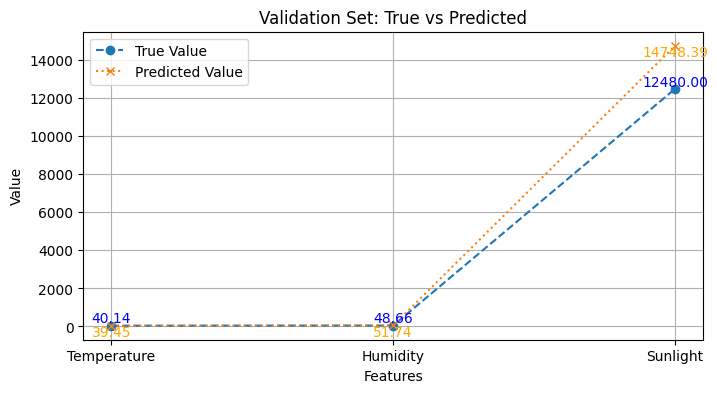

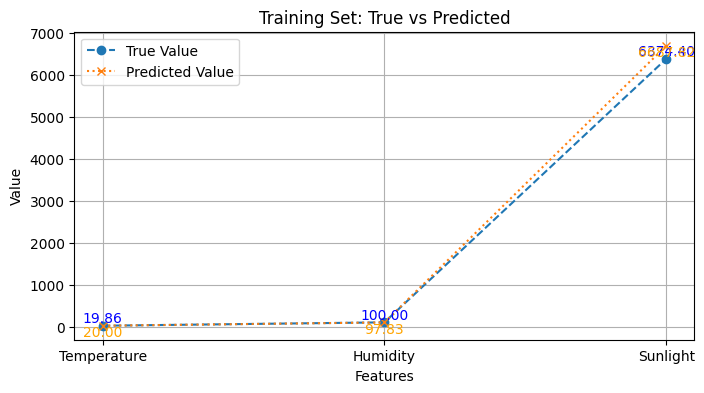

In [37]:
import matplotlib.pyplot as plt

# 繪製實際值與預測值的差異圖並標出數值
def plot_prediction_comparison_with_values(true_values, predicted_values, title, labels=None):
    plt.figure(figsize=(8, 4))

    # 繪製實際值與預測值
    plt.plot(true_values[0], label="True Value", marker="o", linestyle="--")
    plt.plot(predicted_values[0], label="Predicted Value", marker="x", linestyle=":")

    # 標出每個數值
    for i, (t, p) in enumerate(zip(true_values[0], predicted_values[0])):
        label = labels[i] if labels else f"Var {i+1}"
        plt.text(i, t, f"{t:.2f}", ha="center", va="bottom", fontsize=10, color="blue")
        plt.text(i, p, f"{p:.2f}", ha="center", va="top", fontsize=10, color="orange")

    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.xticks(range(len(true_values[0])), labels if labels else [f"Var {i+1}" for i in range(len(true_values[0]))])
    plt.show()

# 特徵名稱（可選）
feature_labels = ["Temperature", "Humidity", "Sunlight"]

# 繪製 Validation Set 結果
plot_prediction_comparison_with_values(
    Y_val_true_original, Y_val_pred_original, "Validation Set: True vs Predicted", labels=feature_labels
)

# 繪製 Training Set 結果
plot_prediction_comparison_with_values(
    Y_train_true_original, Y_train_pred_original, "Training Set: True vs Predicted", labels=feature_labels
)

## 5.Prediction on known dataset


In [38]:
ten_min_ave_filter_test = ten_min_ave_filter_test[
    (ten_min_ave_filter_test['10min_Group'].dt.time >= pd.to_datetime("07:00:00").time()) &
    (ten_min_ave_filter_test['10min_Group'].dt.time < pd.to_datetime("09:00:00").time())
].reset_index(drop=True)
ten_min_ave_filter_test.head(5)

,10min_Group,Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Date,Month,Time,FPCA_Predicted_Power
0,2024-01-01 07:00:00,0.150204,0.508736,0.002397,0.000033,2024-01-01,2024-01,07:00:00,0.117992
1,2024-01-01 07:10:00,0.151790,0.508586,0.003989,0.000061,2024-01-01,2024-01,07:10:00,0.118107
2,2024-01-01 07:20:00,0.153149,0.502662,0.005928,0.000115,2024-01-01,2024-01,07:20:00,0.118234
3,2024-01-01 07:30:00,0.155641,0.496888,0.009081,0.000215,2024-01-01,2024-01,07:30:00,0.118564
4,2024-01-01 07:40:00,0.159266,0.496888,0.016440,0.000556,2024-01-01,2024-01,07:40:00,0.119489


In [39]:

# 初始化存放結果的列表
predicted_all_dates = []

# 模型逐天預測
unique_dates = ten_min_ave_filter_test['Date'].unique()
start_time = datetime.strptime("09:00", "%H:%M")
time_intervals = [start_time + timedelta(minutes=10 * i) for i in range(48)]
df_timestamp= scale_time_to_01(pd.Series(time_intervals))

for current_date in unique_dates:
    # 篩選當天數據 (07:00–08:50)
    day_data = ten_min_ave_filter_test[ten_min_ave_filter_test['Date'] == current_date].reset_index(drop=True)

    # 初始化滑動窗口 (07:00–08:50 的數據作為 X1 初始值)
    sliding_window = day_data.iloc[:12].copy()  # 前 12 筆數據 (07:00–08:50)

    # 初始化 X2 (前一天的 FPCA 或當月平均值)
    previous_date = pd.to_datetime(current_date) - pd.Timedelta(days=1)

    if pd.to_datetime(current_date).strftime('%m-%d') == '01-01':
        # 如果是 1月1日，直接使用當月的 FPCA 平均值
        previous_fpca = fpca_monthly_averages_scaled[
            fpca_monthly_averages_scaled['Month'] == day_data.iloc[0]['Month']
        ]['FPCA_Predicted_Power_Scaled'].values
    else:
        # 否則，嘗試從前一天的數據中獲取 FPCA 預測值
        previous_day_data = ten_min_ave_filter_train[ten_min_ave_filter_train['Date'] == previous_date.strftime('%Y-%m-%d')]
        if previous_day_data.empty:
            # 如果前一天沒有數據，使用當月的 FPCA 平均值
            previous_fpca = fpca_monthly_averages_scaled[
                fpca_monthly_averages_scaled['Month'] == day_data.iloc[0]['Month']
            ]['FPCA_Predicted_Power_Scaled'].values
        else:
            # 使用前一天的 FPCA 預測值
            previous_fpca = previous_day_data['FPCA_Predicted_Power'].values

    # 初始化結果存放
    predicted_results = []
    averaged_results = {}

    # X3 的變數
    df_tmp_ave_temp = average_temp_by_month_time[average_temp_by_month_time['Month']==day_data.iloc[0]['Month']].sort_values('Time').reset_index(drop=True)
    df_tmp_ave_humi = average_humi_by_month_time[average_humi_by_month_time['Month']==day_data.iloc[0]['Month']].sort_values('Time').reset_index(drop=True)
    df_tmp_ave_sun = average_sunlight_by_month_time[average_sunlight_by_month_time['Month']==day_data.iloc[0]['Month']].sort_values('Time').reset_index(drop=True)
    df_tmp_sd_temp = sd_temp_by_month_time[sd_temp_by_month_time['Month']==day_data.iloc[0]['Month']].sort_values('Time').reset_index(drop=True)
    df_tmp_sd_humi = sd_humi_by_month_time[sd_humi_by_month_time['Month']==day_data.iloc[0]['Month']].sort_values('Time').reset_index(drop=True)
    df_tmp_sd_sun = sd_sunlight_by_month_time[sd_sunlight_by_month_time['Month']==day_data.iloc[0]['Month']].sort_values('Time').reset_index(drop=True)

    for step in range(48):  # 預測 48 個時間點 (09:00–16:50)
        # 構造 X1
        X1_input = sliding_window[['Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']].values
        X1_tensor = torch.tensor(X1_input, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 12, 3)

        # 構造 X2
        X2_tensor = torch.tensor(previous_fpca, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)  # (1, 60, 1)

        # 構造 X3
        future_times_scaled = df_timestamp[step:step+6].values
        future_avg_temp = df_tmp_ave_temp[12+step:12+step+6]['Avg_Month_Time_Temp'].values
        future_avg_humi = df_tmp_ave_humi[12+step:12+step+6]['Avg_Month_Time_Humi'].values
        future_avg_sun = df_tmp_ave_sun[12+step:12+step+6]['Avg_Month_Time_Sun'].values
        future_sd_temp = df_tmp_sd_temp[12+step:12+step+6]['Sd_Month_Time_Temp'].values
        future_sd_humi = df_tmp_sd_humi[12+step:12+step+6]['Sd_Month_Time_Humi'].values
        future_sd_sun = df_tmp_sd_sun[12+step:12+step+6]['Sd_Month_Time_Sun'].values

        X3_features = np.column_stack((future_times_scaled, future_avg_temp, future_avg_humi, future_avg_sun, future_sd_temp, future_sd_humi, future_sd_sun))  # (6, 7)
        if len(X3_features) < 6:  # 如果不足 6 步，補零
            padding = np.zeros((6 - len(X3_features), X3_features.shape[1]))
            X3_features = np.vstack((X3_features, padding))
        X3_tensor = torch.tensor(X3_features, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 6, 9)

        # 模型預測
        model.eval()
        predicted = model(X1_tensor, X2_tensor, X3_tensor).cpu().detach().numpy()  # (1, 1, 3)
        predicted_steps = predicted[0]  # (1, 3)

        for idx, time_point in enumerate([time_intervals[step]]):
          if time_point not in averaged_results:
            averaged_results[time_point] = [predicted_steps[idx]]
          else:
            averaged_results[time_point].append(predicted_steps[idx])
        # 即時計算平均值並更新滑動窗口
        averaged_pred = np.mean(averaged_results[time_intervals[step]], axis=0)
        next_row = pd.DataFrame([averaged_pred], columns=['Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)'])

        # 更新滑動窗口
        sliding_window = pd.concat([sliding_window.iloc[1:], next_row], ignore_index=True)  # 滑動窗口向後移動 1 步

    # 平均重疊預測
    final_results = []
    for time_point, preds in averaged_results.items():
        averaged_pred = np.mean(preds, axis=0)  # 平均多次預測值
        final_results.append([time_point] + list(averaged_pred))

    # 將結果轉換為 DataFrame
    predicted_df = pd.DataFrame(final_results, columns=['10min_Group', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)'])
    predicted_df['10min_Group'] = pd.date_range(start=f"{current_date} 09:00", periods=48, freq='10min')
    predicted_all_dates.append(predicted_df)

# 合併所有天數的結果
final_predicted_df_known_data = pd.concat(predicted_all_dates, ignore_index=True)

# 檢視預測結果
final_predicted_df_known_data.head(5)

,10min_Group,Temperature(°C),Humidity(%),Sunlight(Lux)
0,2024-01-01 09:00:00,0.166969,0.504627,0.056035
1,2024-01-01 09:10:00,0.163598,0.504839,0.057864
2,2024-01-01 09:20:00,0.159363,0.501809,0.060344
3,2024-01-01 09:30:00,0.155201,0.498377,0.063049
4,2024-01-01 09:40:00,0.151487,0.494670,0.065777


In [40]:
final_true_df_known_data = ten_min_avg_filter[pd.to_datetime(ten_min_avg_filter['Date']).isin(pd.to_datetime([val_date]))]
final_true_df_known_data = final_true_df_known_data[
    (final_true_df_known_data['10min_Group'].dt.time >= pd.to_datetime("09:00:00").time()) &
    (final_true_df_known_data['10min_Group'].dt.time < pd.to_datetime("17:00:00").time())
].reset_index(drop=True)
final_true_df_known_data[features] = scaler_X.transform(final_true_df_known_data[features])
final_true_df_known_data.head(5)

,10min_Group,Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Date,Month,Time,FPCA_Predicted_Power
0,2024-01-01 09:00:00,0.169008,0.548481,0.069191,17.368,2024-01-01,2024-01,09:00:00,12.640961
1,2024-01-01 09:10:00,0.161985,0.586577,0.057823,12.612,2024-01-01,2024-01,09:10:00,15.250110
2,2024-01-01 09:20:00,0.155415,0.605774,0.048324,8.807,2024-01-01,2024-01,09:20:00,16.539933
3,2024-01-01 09:30:00,0.159266,0.606299,0.072931,17.564,2024-01-01,2024-01,09:30:00,6.796753
4,2024-01-01 09:40:00,0.163344,0.606299,0.047103,7.508,2024-01-01,2024-01,09:40:00,9.321096


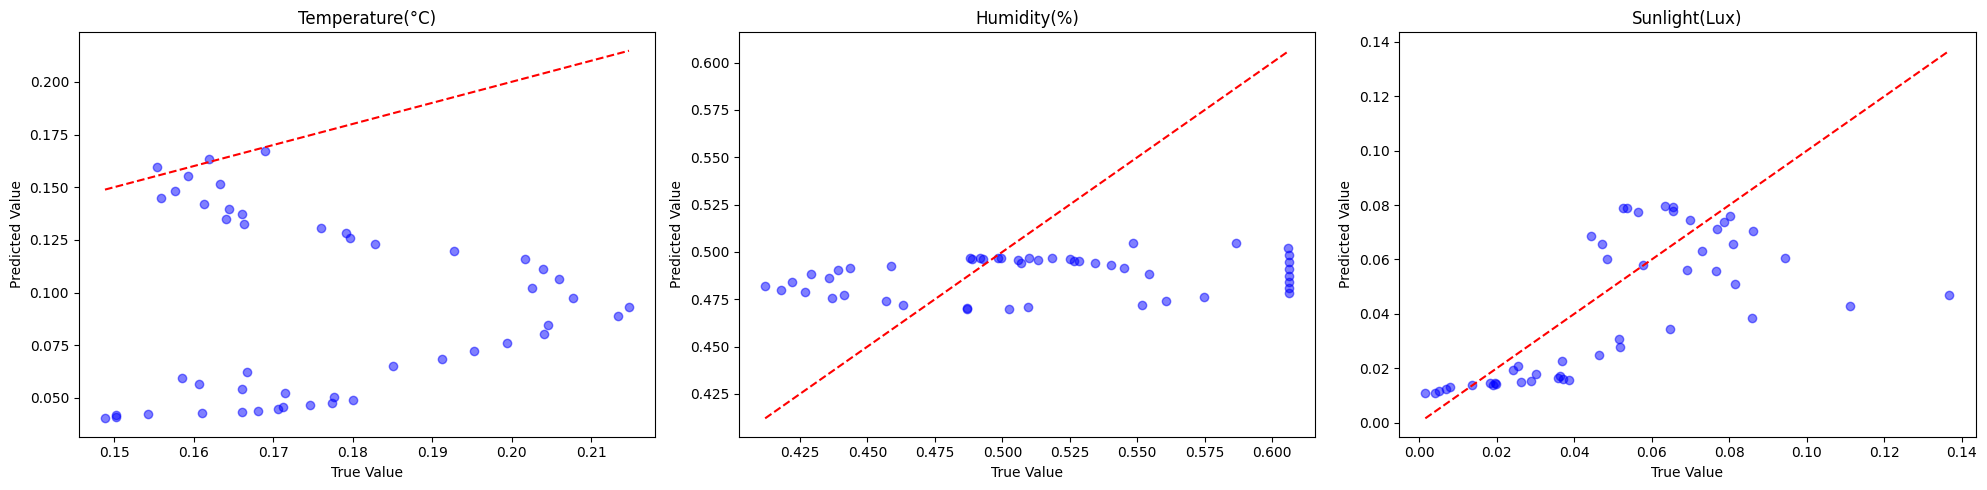

In [41]:
from sklearn.metrics import mean_absolute_error as sk_mae

merged_data_test_true = pd.merge(
    final_predicted_df_known_data,
    final_true_df_known_data,
    on=["10min_Group"],
    suffixes=('_pred', '_true')
)

variables = ['Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, var in enumerate(variables):
    axes[i].scatter(merged_data_test_true[f"{var}_true"], merged_data_test_true[f"{var}_pred"], alpha=0.5, color="blue")
    axes[i].plot([merged_data_test_true[f"{var}_true"].min(), merged_data_test_true[f"{var}_true"].max()],
                 [merged_data_test_true[f"{var}_true"].min(), merged_data_test_true[f"{var}_true"].max()],
                 color="red", linestyle="--")
    axes[i].set_title(var)
    axes[i].set_xlabel("True Value")
    axes[i].set_ylabel("Predicted Value")

plt.tight_layout()
plt.show()


## 6. Prediction on testing data (unknow)

In [42]:
# 初始化存放結果的列表
predicted_all_dates = []

# 模型逐天預測
unique_dates = initial_data_filter_scaled['Date'].unique()
start_time = datetime.strptime("09:00", "%H:%M")
time_intervals = [start_time + timedelta(minutes=10 * i) for i in range(48)]
df_timestamp= scale_time_to_01(pd.Series(time_intervals))

for current_date in unique_dates:
    # 篩選當天數據 (07:00–08:50)
    day_data = initial_data_filter_scaled[initial_data_filter_scaled['Date'] == current_date].reset_index(drop=True)

    # 初始化滑動窗口 (07:00–08:50 的數據作為 X1 初始值)
    sliding_window = day_data.iloc[:12].copy()  # 前 12 筆數據 (07:00–08:50)

    # 初始化 X2 (前一天的 FPCA 或當月平均值)
    previous_date = pd.to_datetime(current_date) - pd.Timedelta(days=1)

    if pd.to_datetime(current_date).strftime('%m-%d') == '01-01':
        # 如果是 1月1日，直接使用當月的 FPCA 平均值
        previous_fpca = fpca_monthly_averages_scaled[
            fpca_monthly_averages_scaled['Month'] == day_data.iloc[0]['Month']
        ]['FPCA_Predicted_Power_Scaled'].values
    else:
        # 否則，嘗試從前一天的數據中獲取 FPCA 預測值
        previous_day_data = ten_min_ave_filter_train[ten_min_ave_filter_train['Date'] == previous_date.strftime('%Y-%m-%d')]
        if previous_day_data.empty:
            # 如果前一天沒有數據，使用當月的 FPCA 平均值
            previous_fpca = fpca_monthly_averages_scaled[
                fpca_monthly_averages_scaled['Month'] == day_data.iloc[0]['Month']
            ]['FPCA_Predicted_Power_Scaled'].values
        else:
            # 使用前一天的 FPCA 預測值
            previous_fpca = previous_day_data['FPCA_Predicted_Power'].values

    # 初始化結果存放
    predicted_results = []
    averaged_results = {}

    # X3 的變數
    df_tmp_ave_temp = average_temp_by_month_time[average_temp_by_month_time['Month']==day_data.iloc[0]['Month']].sort_values('Time').reset_index(drop=True)
    df_tmp_ave_humi = average_humi_by_month_time[average_humi_by_month_time['Month']==day_data.iloc[0]['Month']].sort_values('Time').reset_index(drop=True)
    df_tmp_ave_sun = average_sunlight_by_month_time[average_sunlight_by_month_time['Month']==day_data.iloc[0]['Month']].sort_values('Time').reset_index(drop=True)
    df_tmp_sd_temp = sd_temp_by_month_time[sd_temp_by_month_time['Month']==day_data.iloc[0]['Month']].sort_values('Time').reset_index(drop=True)
    df_tmp_sd_humi = sd_humi_by_month_time[sd_humi_by_month_time['Month']==day_data.iloc[0]['Month']].sort_values('Time').reset_index(drop=True)
    df_tmp_sd_sun = sd_sunlight_by_month_time[sd_sunlight_by_month_time['Month']==day_data.iloc[0]['Month']].sort_values('Time').reset_index(drop=True)

    for step in range(48):  # 預測 48 個時間點 (09:00–16:50)
        # 構造 X1
        X1_input = sliding_window[['Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']].values
        X1_tensor = torch.tensor(X1_input, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 12, 3)

        # 構造 X2
        X2_tensor = torch.tensor(previous_fpca, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)  # (1, 60, 1)

        # 構造 X3
        future_times_scaled = df_timestamp[step:step+6].values
        future_avg_temp = df_tmp_ave_temp[12+step:12+step+6]['Avg_Month_Time_Temp'].values
        future_avg_humi = df_tmp_ave_humi[12+step:12+step+6]['Avg_Month_Time_Humi'].values
        future_avg_sun = df_tmp_ave_sun[12+step:12+step+6]['Avg_Month_Time_Sun'].values
        future_sd_temp = df_tmp_sd_temp[12+step:12+step+6]['Sd_Month_Time_Temp'].values
        future_sd_humi = df_tmp_sd_humi[12+step:12+step+6]['Sd_Month_Time_Humi'].values
        future_sd_sun = df_tmp_sd_sun[12+step:12+step+6]['Sd_Month_Time_Sun'].values

        X3_features = np.column_stack((future_times_scaled, future_avg_temp, future_avg_humi, future_avg_sun, future_sd_temp, future_sd_humi, future_sd_sun))  # (6, 7)
        if len(X3_features) < 6:  # 如果不足 6 步，補零
            padding = np.zeros((6 - len(X3_features), X3_features.shape[1]))
            X3_features = np.vstack((X3_features, padding))
        X3_tensor = torch.tensor(X3_features, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 6, 9)

        # 模型預測
        model.eval()
        predicted = model(X1_tensor, X2_tensor, X3_tensor).cpu().detach().numpy()  # (1, 1, 3)
        predicted_steps = predicted[0]  # (1, 3)

        for idx, time_point in enumerate([time_intervals[step]]):
          if time_point not in averaged_results:
            averaged_results[time_point] = [predicted_steps[idx]]
          else:
            averaged_results[time_point].append(predicted_steps[idx])
        # 即時計算平均值並更新滑動窗口
        averaged_pred = np.mean(averaged_results[time_intervals[step]], axis=0)
        next_row = pd.DataFrame([averaged_pred], columns=['Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)'])

        # 更新滑動窗口
        sliding_window = pd.concat([sliding_window.iloc[1:], next_row], ignore_index=True)  # 滑動窗口向後移動 1 步

    # 平均重疊預測
    final_results = []
    for time_point, preds in averaged_results.items():
        averaged_pred = np.mean(preds, axis=0)  # 平均多次預測值
        final_results.append([time_point] + list(averaged_pred))

    # 將結果轉換為 DataFrame
    predicted_df = pd.DataFrame(final_results, columns=['10min_Group', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)'])
    predicted_df['10min_Group'] = pd.date_range(start=f"{current_date} 09:00", periods=48, freq='10min')
    predicted_all_dates.append(predicted_df)

# 合併所有天數的結果
final_predicted_df = pd.concat(predicted_all_dates, ignore_index=True)

# 檢視預測結果
final_predicted_df.head(5)

,10min_Group,Temperature(°C),Humidity(%),Sunlight(Lux)
0,2024-01-06 09:00:00,0.403187,0.217406,0.536467
1,2024-01-06 09:10:00,0.406389,0.201229,0.588561
2,2024-01-06 09:20:00,0.415200,0.184001,0.615661
3,2024-01-06 09:30:00,0.420318,0.171401,0.619175
4,2024-01-06 09:40:00,0.420169,0.161535,0.626477


In [43]:
final_predicted_df['Date'] = pd.to_datetime(final_predicted_df['10min_Group']).dt.date
final_predicted_df['Time'] = final_predicted_df['10min_Group'].dt.time
final_predicted_df['Date'] = final_predicted_df['Date'].apply(lambda d: d.strftime('%Y-%m-%d'))  # 格式化為 YYYYMMDD
final_predicted_df['Time'] = final_predicted_df['Time'].apply(lambda t: t.strftime('%H:%M:%S'))  # 格式化為 HHMM
final_predicted_df

,10min_Group,Temperature(°C),Humidity(%),Sunlight(Lux),Date,Time
0,2024-01-06 09:00:00,0.403187,0.217406,0.536467,2024-01-06,09:00:00
1,2024-01-06 09:10:00,0.406389,0.201229,0.588561,2024-01-06,09:10:00
2,2024-01-06 09:20:00,0.415200,0.184001,0.615661,2024-01-06,09:20:00
3,2024-01-06 09:30:00,0.420318,0.171401,0.619175,2024-01-06,09:30:00
4,2024-01-06 09:40:00,0.420169,0.161535,0.626477,2024-01-06,09:40:00
...,...,...,...,...,...,...
1147,2024-07-15 16:10:00,0.525423,0.329225,0.124098,2024-07-15,16:10:00
1148,2024-07-15 16:20:00,0.506752,0.357065,0.103064,2024-07-15,16:20:00
1149,2024-07-15 16:30:00,0.486195,0.388672,0.081955,2024-07-15,16:30:00
1150,2024-07-15 16:40:00,0.461424,0.425865,0.062782,2024-07-15,16:40:00


## 7. Prediction on training data and train a ML model

In [44]:
ten_min_ave_filter_train_pre = ten_min_ave_filter_train[
    (ten_min_ave_filter_train['10min_Group'].dt.time >= pd.to_datetime("07:00:00").time()) &
    (ten_min_ave_filter_train['10min_Group'].dt.time < pd.to_datetime("09:00:00").time())
].reset_index(drop=True)
ten_min_ave_filter_train_pre.head(5)

,10min_Group,Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Date,Month,Time,FPCA_Predicted_Power,Avg_Month_Time_Temp,Avg_Month_Time_Humi,Avg_Month_Time_Sun,Sd_Month_Time_Temp,Sd_Month_Time_Humi,Sd_Month_Time_Sun
0,2024-01-02 07:00:00,0.048029,0.606299,0.035116,0.004137,2024-01-02,2024-01,07:00:00,0.126974,0.087504,0.606299,0.015351,0.046539,0.000000,0.012240
1,2024-01-02 07:10:00,0.080879,0.606299,0.066303,0.017974,2024-01-02,2024-01,07:10:00,0.137108,0.095125,0.606299,0.025716,0.046308,0.000000,0.019888
2,2024-01-02 07:20:00,0.106026,0.606299,0.072299,0.014434,2024-01-02,2024-01,07:20:00,0.152376,0.105583,0.606299,0.037793,0.048709,0.000000,0.032706
3,2024-01-02 07:30:00,0.121658,0.606299,0.126321,0.050680,2024-01-02,2024-01,07:30:00,0.169469,0.114773,0.605492,0.047990,0.053758,0.004034,0.039805
4,2024-01-02 07:40:00,0.183507,0.606299,0.214850,0.132409,2024-01-02,2024-01,07:40:00,0.220930,0.124839,0.600432,0.069790,0.059744,0.027770,0.070764


In [45]:
# 初始化存放結果的列表
predicted_all_dates = []

# 模型逐天預測
unique_dates = ten_min_ave_filter_train_pre['Date'].unique()
start_time = datetime.strptime("09:00", "%H:%M")
time_intervals = [start_time + timedelta(minutes=10 * i) for i in range(48)]
df_timestamp= scale_time_to_01(pd.Series(time_intervals))

for current_date in unique_dates:
    # 篩選當天數據 (07:00–08:50)
    day_data = ten_min_ave_filter_train_pre[ten_min_ave_filter_train_pre['Date'] == current_date].reset_index(drop=True)

    # 初始化滑動窗口 (07:00–08:50 的數據作為 X1 初始值)
    sliding_window = day_data.iloc[:12].copy()  # 前 12 筆數據 (07:00–08:50)

    # 初始化 X2 (前一天的 FPCA 或當月平均值)
    previous_date = pd.to_datetime(current_date) - pd.Timedelta(days=1)

    if pd.to_datetime(current_date).strftime('%m-%d') == '01-01':
        # 如果是 1月1日，直接使用當月的 FPCA 平均值
        previous_fpca = fpca_monthly_averages_scaled[
            fpca_monthly_averages_scaled['Month'] == day_data.iloc[0]['Month']
        ]['FPCA_Predicted_Power_Scaled'].values
    else:
        # 否則，嘗試從前一天的數據中獲取 FPCA 預測值
        previous_day_data = ten_min_ave_filter_train[ten_min_ave_filter_train['Date'] == previous_date.strftime('%Y-%m-%d')]
        if previous_day_data.empty:
            # 如果前一天沒有數據，使用當月的 FPCA 平均值
            previous_fpca = fpca_monthly_averages_scaled[
                fpca_monthly_averages_scaled['Month'] == day_data.iloc[0]['Month']
            ]['FPCA_Predicted_Power_Scaled'].values
        else:
            # 使用前一天的 FPCA 預測值
            previous_fpca = previous_day_data['FPCA_Predicted_Power'].values

    # 初始化結果存放
    predicted_results = []
    averaged_results = {}

    # X3 的變數
    df_tmp_ave_temp = average_temp_by_month_time[average_temp_by_month_time['Month']==day_data.iloc[0]['Month']].sort_values('Time').reset_index(drop=True)
    df_tmp_ave_humi = average_humi_by_month_time[average_humi_by_month_time['Month']==day_data.iloc[0]['Month']].sort_values('Time').reset_index(drop=True)
    df_tmp_ave_sun = average_sunlight_by_month_time[average_sunlight_by_month_time['Month']==day_data.iloc[0]['Month']].sort_values('Time').reset_index(drop=True)
    df_tmp_sd_temp = sd_temp_by_month_time[sd_temp_by_month_time['Month']==day_data.iloc[0]['Month']].sort_values('Time').reset_index(drop=True)
    df_tmp_sd_humi = sd_humi_by_month_time[sd_humi_by_month_time['Month']==day_data.iloc[0]['Month']].sort_values('Time').reset_index(drop=True)
    df_tmp_sd_sun = sd_sunlight_by_month_time[sd_sunlight_by_month_time['Month']==day_data.iloc[0]['Month']].sort_values('Time').reset_index(drop=True)

    for step in range(48):  # 預測 48 個時間點 (09:00–16:50)
        # 構造 X1
        X1_input = sliding_window[['Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']].values
        X1_tensor = torch.tensor(X1_input, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 12, 3)

        # 構造 X2
        X2_tensor = torch.tensor(previous_fpca, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)  # (1, 60, 1)

        # 構造 X3
        future_times_scaled = df_timestamp[step:step+6].values
        future_avg_temp = df_tmp_ave_temp[12+step:12+step+6]['Avg_Month_Time_Temp'].values
        future_avg_humi = df_tmp_ave_humi[12+step:12+step+6]['Avg_Month_Time_Humi'].values
        future_avg_sun = df_tmp_ave_sun[12+step:12+step+6]['Avg_Month_Time_Sun'].values
        future_sd_temp = df_tmp_sd_temp[12+step:12+step+6]['Sd_Month_Time_Temp'].values
        future_sd_humi = df_tmp_sd_humi[12+step:12+step+6]['Sd_Month_Time_Humi'].values
        future_sd_sun = df_tmp_sd_sun[12+step:12+step+6]['Sd_Month_Time_Sun'].values

        X3_features = np.column_stack((future_times_scaled, future_avg_temp, future_avg_humi, future_avg_sun, future_sd_temp, future_sd_humi, future_sd_sun))  # (6, 7)
        if len(X3_features) < 6:  # 如果不足 6 步，補零
            padding = np.zeros((6 - len(X3_features), X3_features.shape[1]))
            X3_features = np.vstack((X3_features, padding))
        X3_tensor = torch.tensor(X3_features, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 6, 9)

        # 模型預測
        model.eval()
        predicted = model(X1_tensor, X2_tensor, X3_tensor).cpu().detach().numpy()  # (1, 1, 3)
        predicted_steps = predicted[0]  # (1, 3)

        for idx, time_point in enumerate([time_intervals[step]]):
          if time_point not in averaged_results:
            averaged_results[time_point] = [predicted_steps[idx]]
          else:
            averaged_results[time_point].append(predicted_steps[idx])
        # 即時計算平均值並更新滑動窗口
        averaged_pred = np.mean(averaged_results[time_intervals[step]], axis=0)
        next_row = pd.DataFrame([averaged_pred], columns=['Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)'])

        # 更新滑動窗口
        sliding_window = pd.concat([sliding_window.iloc[1:], next_row], ignore_index=True)  # 滑動窗口向後移動 1 步

    # 平均重疊預測
    final_results = []
    for time_point, preds in averaged_results.items():
        averaged_pred = np.mean(preds, axis=0)  # 平均多次預測值
        final_results.append([time_point] + list(averaged_pred))

    # 將結果轉換為 DataFrame
    predicted_df = pd.DataFrame(final_results, columns=['10min_Group', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)'])
    predicted_df['10min_Group'] = pd.date_range(start=f"{current_date} 09:00", periods=48, freq='10min')
    predicted_all_dates.append(predicted_df)

# 合併所有天數的結果
final_predicted_df_known_train_data = pd.concat(predicted_all_dates, ignore_index=True)

# 檢視預測結果
final_predicted_df_known_train_data.head(5)

,10min_Group,Temperature(°C),Humidity(%),Sunlight(Lux)
0,2024-01-02 09:00:00,0.416961,0.228617,0.591565
1,2024-01-02 09:10:00,0.424653,0.209525,0.608600
2,2024-01-02 09:20:00,0.428601,0.192071,0.622355
3,2024-01-02 09:30:00,0.430640,0.177317,0.634849
4,2024-01-02 09:40:00,0.432115,0.165198,0.644200


In [46]:
final_true_df_known_train_data = ten_min_avg_filter[~pd.to_datetime(ten_min_avg_filter['Date']).isin(pd.to_datetime([val_date]))]
final_true_df_known_train_data = final_true_df_known_train_data[
    (final_true_df_known_train_data['10min_Group'].dt.time >= pd.to_datetime("09:00:00").time()) &
    (final_true_df_known_train_data['10min_Group'].dt.time < pd.to_datetime("17:00:00").time())
].reset_index(drop=True)
final_true_df_known_train_data.head(5)

,10min_Group,Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Date,Month,Time,FPCA_Predicted_Power
0,2024-01-02 09:00:00,31.010000,47.780000,70884.743000,1277.553000,2024-01-02,2024-01,09:00:00,1384.384988
1,2024-01-02 09:10:00,32.070000,45.060000,75632.265000,1369.803000,2024-01-02,2024-01,09:10:00,1527.129284
2,2024-01-02 09:20:00,32.711111,41.555556,81495.068889,1462.673333,2024-01-02,2024-01,09:20:00,1539.385002
3,2024-01-02 09:30:00,32.200000,41.670000,89049.711000,1540.396000,2024-01-02,2024-01,09:30:00,1239.715466
4,2024-01-02 09:40:00,32.890000,39.650000,97289.460000,1594.301000,2024-01-02,2024-01,09:40:00,1369.051855


In [47]:
merged_data_train_true = pd.merge(
    final_predicted_df_known_train_data,
    final_true_df_known_train_data,
    on=["10min_Group"],
    suffixes=('_pred', '_true')
)

merged_data_train_true.head()

,10min_Group,Temperature(°C)_pred,Humidity(%)_pred,Sunlight(Lux)_pred,Temperature(°C)_true,Humidity(%)_true,Sunlight(Lux)_true,Power(mW),Date,Month,Time,FPCA_Predicted_Power
0,2024-01-02 09:00:00,0.416961,0.228617,0.591565,31.010000,47.780000,70884.743000,1277.553000,2024-01-02,2024-01,09:00:00,1384.384988
1,2024-01-02 09:10:00,0.424653,0.209525,0.608600,32.070000,45.060000,75632.265000,1369.803000,2024-01-02,2024-01,09:10:00,1527.129284
2,2024-01-02 09:20:00,0.428601,0.192071,0.622355,32.711111,41.555556,81495.068889,1462.673333,2024-01-02,2024-01,09:20:00,1539.385002
3,2024-01-02 09:30:00,0.430640,0.177317,0.634849,32.200000,41.670000,89049.711000,1540.396000,2024-01-02,2024-01,09:30:00,1239.715466
4,2024-01-02 09:40:00,0.432115,0.165198,0.644200,32.890000,39.650000,97289.460000,1594.301000,2024-01-02,2024-01,09:40:00,1369.051855


In [48]:
merged_train_data_with_pred = pd.concat([merged_data_train_true,merged_data_test_true]).reset_index(drop=True)
merged_train_data_with_pred = merged_train_data_with_pred.drop(columns=['Temperature(°C)_true','Humidity(%)_true','Sunlight(Lux)_true','FPCA_Predicted_Power'])
merged_train_data_with_pred['Date'] = pd.to_datetime(merged_train_data_with_pred['Date'])
merged_train_data_with_pred.head()

,10min_Group,Temperature(°C)_pred,Humidity(%)_pred,Sunlight(Lux)_pred,Power(mW),Date,Month,Time
0,2024-01-02 09:00:00,0.416961,0.228617,0.591565,1277.553000,2024-01-02,2024-01,09:00:00
1,2024-01-02 09:10:00,0.424653,0.209525,0.608600,1369.803000,2024-01-02,2024-01,09:10:00
2,2024-01-02 09:20:00,0.428601,0.192071,0.622355,1462.673333,2024-01-02,2024-01,09:20:00
3,2024-01-02 09:30:00,0.430640,0.177317,0.634849,1540.396000,2024-01-02,2024-01,09:30:00
4,2024-01-02 09:40:00,0.432115,0.165198,0.644200,1594.301000,2024-01-02,2024-01,09:40:00


In [49]:
final_predicted_df.columns = ['10min_Group','Temperature(°C)_pred','Humidity(%)_pred','Sunlight(Lux)_pred','Date','Time']
# 確保 'Date' 欄位是 datetime 型別
final_predicted_df['Date'] = pd.to_datetime(final_predicted_df['Date'])

# 從 'Date' 提取月份並轉換為 Period 型別
final_predicted_df['Month'] = pd.PeriodIndex(final_predicted_df['Date'], freq='M')
final_predicted_df['Time'] = pd.to_datetime(final_predicted_df['Time']).dt.time
final_predicted_df.head(5)

<ipython-input-49-d0674750168a>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  final_predicted_df['Time'] = pd.to_datetime(final_predicted_df['Time']).dt.time


,10min_Group,Temperature(°C)_pred,Humidity(%)_pred,Sunlight(Lux)_pred,Date,Time,Month
0,2024-01-06 09:00:00,0.403187,0.217406,0.536467,2024-01-06,09:00:00,2024-01
1,2024-01-06 09:10:00,0.406389,0.201229,0.588561,2024-01-06,09:10:00,2024-01
2,2024-01-06 09:20:00,0.415200,0.184001,0.615661,2024-01-06,09:20:00,2024-01
3,2024-01-06 09:30:00,0.420318,0.171401,0.619175,2024-01-06,09:30:00,2024-01
4,2024-01-06 09:40:00,0.420169,0.161535,0.626477,2024-01-06,09:40:00,2024-01


In [50]:
merged_train_data_with_pred = merged_train_data_with_pred.merge(
    average_power_by_month_time, on=['Month', 'Time'], how='left'
)

merged_train_data_with_pred = merged_train_data_with_pred.merge(
    sd_power_by_month_time, on=['Month', 'Time'], how='left'
)

merged_train_data_with_pred.head()

,10min_Group,Temperature(°C)_pred,Humidity(%)_pred,Sunlight(Lux)_pred,Power(mW),Date,Month,Time,Avg_Month_Time_Power,Sd_Month_Time_Power
0,2024-01-02 09:00:00,0.416961,0.228617,0.591565,1277.553000,2024-01-02,2024-01,09:00:00,0.211025,0.286003
1,2024-01-02 09:10:00,0.424653,0.209525,0.608600,1369.803000,2024-01-02,2024-01,09:10:00,0.261157,0.294721
2,2024-01-02 09:20:00,0.428601,0.192071,0.622355,1462.673333,2024-01-02,2024-01,09:20:00,0.251875,0.292539
3,2024-01-02 09:30:00,0.430640,0.177317,0.634849,1540.396000,2024-01-02,2024-01,09:30:00,0.252339,0.315242
4,2024-01-02 09:40:00,0.432115,0.165198,0.644200,1594.301000,2024-01-02,2024-01,09:40:00,0.277711,0.329014


In [51]:
fpca_monthly_averages_scaled['Time'] = fpca_monthly_averages_scaled['Time'].apply(
    lambda x: datetime.strptime(x, "%H:%M:%S").time()
)

In [52]:
merged_train_data_with_pred = merged_train_data_with_pred.merge(
    fpca_monthly_averages_scaled, on=['Month', 'Time'], how='left'
)
merged_train_data_with_pred = merged_train_data_with_pred.drop(columns=['FPCA_Predicted_Power'])
merged_train_data_with_pred.head()

,10min_Group,Temperature(°C)_pred,Humidity(%)_pred,Sunlight(Lux)_pred,Power(mW),Date,Month,Time,Avg_Month_Time_Power,Sd_Month_Time_Power,FPCA_Predicted_Power_Scaled
0,2024-01-02 09:00:00,0.416961,0.228617,0.591565,1277.553000,2024-01-02,2024-01,09:00:00,0.211025,0.286003,0.282416
1,2024-01-02 09:10:00,0.424653,0.209525,0.608600,1369.803000,2024-01-02,2024-01,09:10:00,0.261157,0.294721,0.314136
2,2024-01-02 09:20:00,0.428601,0.192071,0.622355,1462.673333,2024-01-02,2024-01,09:20:00,0.251875,0.292539,0.321336
3,2024-01-02 09:30:00,0.430640,0.177317,0.634849,1540.396000,2024-01-02,2024-01,09:30:00,0.252339,0.315242,0.318183
4,2024-01-02 09:40:00,0.432115,0.165198,0.644200,1594.301000,2024-01-02,2024-01,09:40:00,0.277711,0.329014,0.334071


In [53]:
merged_final_predicted_df = final_predicted_df.merge(
    average_power_by_month_time, on=['Month', 'Time'], how='left'
)

merged_final_predicted_df = merged_final_predicted_df.merge(
    sd_power_by_month_time, on=['Month', 'Time'], how='left'
)

merged_final_predicted_df = merged_final_predicted_df.merge(
    fpca_monthly_averages_scaled, on=['Month', 'Time'], how='left'
)
merged_final_predicted_df = merged_final_predicted_df.drop(columns=['FPCA_Predicted_Power'])
merged_final_predicted_df.head()

,10min_Group,Temperature(°C)_pred,Humidity(%)_pred,Sunlight(Lux)_pred,Date,Time,Month,Avg_Month_Time_Power,Sd_Month_Time_Power,FPCA_Predicted_Power_Scaled
0,2024-01-06 09:00:00,0.403187,0.217406,0.536467,2024-01-06,09:00:00,2024-01,0.211025,0.286003,0.282416
1,2024-01-06 09:10:00,0.406389,0.201229,0.588561,2024-01-06,09:10:00,2024-01,0.261157,0.294721,0.314136
2,2024-01-06 09:20:00,0.415200,0.184001,0.615661,2024-01-06,09:20:00,2024-01,0.251875,0.292539,0.321336
3,2024-01-06 09:30:00,0.420318,0.171401,0.619175,2024-01-06,09:30:00,2024-01,0.252339,0.315242,0.318183
4,2024-01-06 09:40:00,0.420169,0.161535,0.626477,2024-01-06,09:40:00,2024-01,0.277711,0.329014,0.334071


In [54]:
def swap_columns(df, col1, col2):
    cols = list(df.columns)
    idx1, idx2 = cols.index(col1), cols.index(col2)
    cols[idx1], cols[idx2] = cols[idx2], cols[idx1]
    return df[cols]

# 使用函數交換欄位 A 和 C
merged_final_predicted_df = swap_columns(merged_final_predicted_df, 'Time', 'Month')
merged_final_predicted_df

,10min_Group,Temperature(°C)_pred,Humidity(%)_pred,Sunlight(Lux)_pred,Date,Month,Time,Avg_Month_Time_Power,Sd_Month_Time_Power,FPCA_Predicted_Power_Scaled
0,2024-01-06 09:00:00,0.403187,0.217406,0.536467,2024-01-06,2024-01,09:00:00,0.211025,0.286003,0.282416
1,2024-01-06 09:10:00,0.406389,0.201229,0.588561,2024-01-06,2024-01,09:10:00,0.261157,0.294721,0.314136
2,2024-01-06 09:20:00,0.415200,0.184001,0.615661,2024-01-06,2024-01,09:20:00,0.251875,0.292539,0.321336
3,2024-01-06 09:30:00,0.420318,0.171401,0.619175,2024-01-06,2024-01,09:30:00,0.252339,0.315242,0.318183
4,2024-01-06 09:40:00,0.420169,0.161535,0.626477,2024-01-06,2024-01,09:40:00,0.277711,0.329014,0.334071
...,...,...,...,...,...,...,...,...,...,...
1147,2024-07-15 16:10:00,0.525423,0.329225,0.124098,2024-07-15,2024-07,16:10:00,0.032694,0.030861,0.144516
1148,2024-07-15 16:20:00,0.506752,0.357065,0.103064,2024-07-15,2024-07,16:20:00,0.018865,0.016724,0.132955
1149,2024-07-15 16:30:00,0.486195,0.388672,0.081955,2024-07-15,2024-07,16:30:00,0.013646,0.011132,0.128731
1150,2024-07-15 16:40:00,0.461424,0.425865,0.062782,2024-07-15,2024-07,16:40:00,0.008843,0.007381,0.124585


## 7-1 Train ML model

In [58]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from xgboost import XGBRegressor, cv, DMatrix
import xgboost as xgb

# 分離解釋變數與目標變數
X = merged_train_data_with_pred.drop(columns=['10min_Group', 'Power(mW)'])
y = merged_train_data_with_pred['Power(mW)']

X['Date'] = pd.to_datetime(X['Date']).dt.day

# 切分訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=30)

# 將時間相關欄位轉換為 category 型別
categorical_columns = ['Date', 'Time', 'Month']
for col in categorical_columns:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
    if col in X_test.columns:
        X_test[col] = X_test[col].astype('category')


# 將資料轉換為 DMatrix 格式
dtrain = DMatrix(X_train, label=y_train,enable_categorical=True)

# 定義參數範圍
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.1
}

# 使用 XGBoost 的交叉驗證功能來選擇最佳 n_estimators
cv_results = cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,  # 最大迭代次數
    early_stopping_rounds=50,  # 提前停止條件
    nfold=5,  # 5 折交叉驗證
    seed=42,
    as_pandas=True,
    verbose_eval=True
)

# 選擇最佳的 n_estimators
best_n_estimators = len(cv_results)
print(f"Best n_estimators: {best_n_estimators}")

# 用最佳參數訓練模型
xgb_model = XGBRegressor(
    n_estimators=best_n_estimators,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    enable_categorical=True
)

xgb_model.fit(X_train, y_train)

# 預測
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)


# 確保 categorical_columns 是正確的
categorical_columns = ['Date', 'Time', 'Month']

# 檢查並轉換為字符串
for col in categorical_columns:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype(str)
    if col in X_test.columns:
        X_test[col] = X_test[col].astype(str)

catboost_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    cat_features=[X_train.columns.get_loc(col) for col in categorical_columns],
    verbose=0,
    random_seed=42
)
catboost_model.fit(X_train, y_train)

catboost_pred = catboost_model.predict(X_test)

# 4. 加權平均進行 Ensemble
ensemble_pred = 0.6 * y_pred_test + 0.4 * catboost_pred  # 權重可以根據驗證集調整

# 5. 評估
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    sae = np.sum(np.abs(y_true - y_pred))
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, SAE: {sae:.2f}")

# 個別模型評估
evaluate_model(y_test, y_pred_test, "XGBoost")
evaluate_model(y_test, catboost_pred, "CatBoost")

# Ensemble 模型評估
evaluate_model(y_test, ensemble_pred, "Ensemble Model")


[0]	train-rmse:510.03581+3.38446	test-rmse:513.69179+12.69546
[1]	train-rmse:473.07476+3.53269	test-rmse:480.20395+11.37162
[2]	train-rmse:440.16705+3.80733	test-rmse:450.87507+9.53523
[3]	train-rmse:410.14768+3.77140	test-rmse:424.58125+8.80942
[4]	train-rmse:383.80328+3.34053	test-rmse:401.88416+7.81995
[5]	train-rmse:359.96061+3.47007	test-rmse:382.11619+6.62480
[6]	train-rmse:338.42354+3.40087	test-rmse:365.15783+6.03040
[7]	train-rmse:319.36221+3.74364	test-rmse:349.81663+5.40751
[8]	train-rmse:302.17446+3.15382	test-rmse:336.77781+5.07950
[9]	train-rmse:287.58423+2.98437	test-rmse:325.60245+5.10389
[10]	train-rmse:274.18313+2.72758	test-rmse:316.44915+4.92837
[11]	train-rmse:262.05617+2.35445	test-rmse:307.75224+4.93742
[12]	train-rmse:251.26533+2.38894	test-rmse:300.88324+5.09637
[13]	train-rmse:242.00769+2.87274	test-rmse:294.89038+5.19221
[14]	train-rmse:233.61114+2.70258	test-rmse:289.82540+5.15036
[15]	train-rmse:225.71709+2.67342	test-rmse:285.38274+5.76529
[16]	train-rmse:

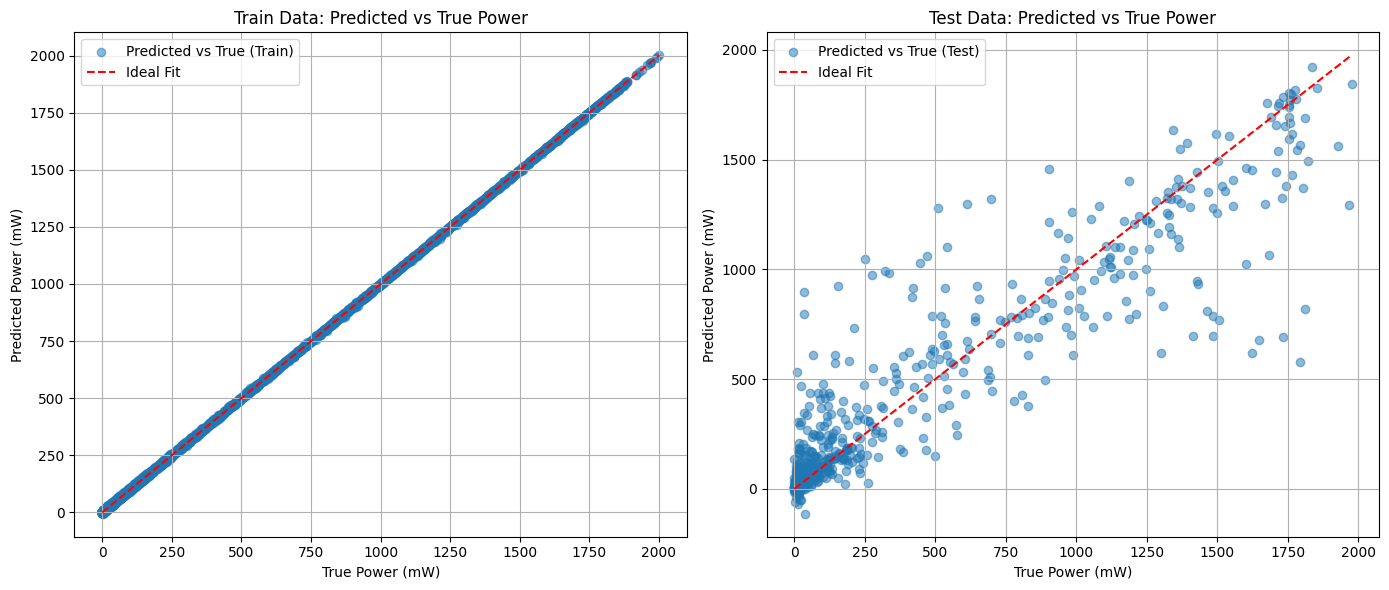

In [59]:
# Assuming y_train, y_pred_train, y_test, and y_pred_test are available

# Create scatter plot for train data
plt.figure(figsize=(14, 6))

# Train data scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5, label="Predicted vs True (Train)")
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--', label="Ideal Fit")
plt.xlabel("True Power (mW)")
plt.ylabel("Predicted Power (mW)")
plt.title("Train Data: Predicted vs True Power")
plt.legend()
plt.grid(True)

# Test data scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5, label="Predicted vs True (Test)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Ideal Fit")
plt.xlabel("True Power (mW)")
plt.ylabel("Predicted Power (mW)")
plt.title("Test Data: Predicted vs True Power")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

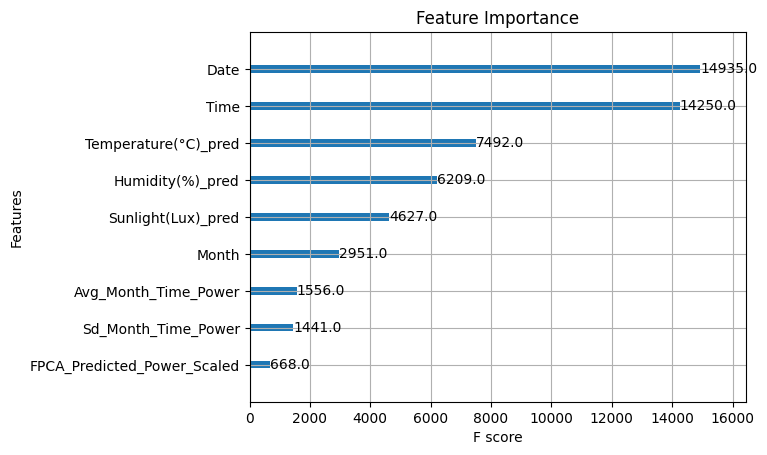

In [60]:
import xgboost as xgb

# Plot feature importance using XGBoost's built-in plot function
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, title="Feature Importance")
plt.show()

In [61]:
merged_final_predicted_df_ML = merged_final_predicted_df.copy()
merged_final_predicted_df_ML['Date'] = pd.to_datetime(merged_final_predicted_df_ML['Date']).dt.day

# 確保 Date, Time, Month 欄位被轉換為 category 型別
categorical_columns = ['Date', 'Time', 'Month']
for col in categorical_columns:
    if col in merged_final_predicted_df_ML.columns:
        merged_final_predicted_df_ML[col] = merged_final_predicted_df_ML[col].astype('category')

# 準備模型輸入特徵
X_test_final = merged_final_predicted_df_ML.drop(columns=['10min_Group'])

# 使用 XGBoost 模型進行預測
X_test_final = X_test_final[X_train.columns]
Power_Pred_xg = xgb_model.predict(X_test_final)

# 確保 categorical_columns 是正確的
categorical_columns = ['Date', 'Time', 'Month']

# 檢查並轉換為字符串
for col in categorical_columns:
    if col in merged_final_predicted_df_ML.columns:
        merged_final_predicted_df_ML[col] = merged_final_predicted_df_ML[col].astype(str)

X_test_final = merged_final_predicted_df_ML.drop(columns=['10min_Group'])
Power_Pred_cb = catboost_model.predict(X_test_final)

merged_final_predicted_df_ML['Final_Power_Pred'] = 0.6*Power_Pred_xg + 0.4*Power_Pred_cb

# 針對預測結果小於 0 的部分改成 0
merged_final_predicted_df_ML['Final_Power_Pred'] = merged_final_predicted_df_ML['Final_Power_Pred'].apply(
    lambda x: max(x, 0)
)

# 查看結果
merged_final_predicted_df_ML.head()

,10min_Group,Temperature(°C)_pred,Humidity(%)_pred,Sunlight(Lux)_pred,Date,Month,Time,Avg_Month_Time_Power,Sd_Month_Time_Power,FPCA_Predicted_Power_Scaled,Final_Power_Pred
0,2024-01-06 09:00:00,0.403187,0.217406,0.536467,6,2024-01,09:00:00,0.211025,0.286003,0.282416,774.801175
1,2024-01-06 09:10:00,0.406389,0.201229,0.588561,6,2024-01,09:10:00,0.261157,0.294721,0.314136,1288.382610
2,2024-01-06 09:20:00,0.415200,0.184001,0.615661,6,2024-01,09:20:00,0.251875,0.292539,0.321336,1378.340882
3,2024-01-06 09:30:00,0.420318,0.171401,0.619175,6,2024-01,09:30:00,0.252339,0.315242,0.318183,1361.210763
4,2024-01-06 09:40:00,0.420169,0.161535,0.626477,6,2024-01,09:40:00,0.277711,0.329014,0.334071,1567.630412


In [62]:
merged_final_predicted_df_ML['label'] = merged_final_predicted_df_ML.apply(
    lambda row: row['10min_Group'].strftime('%Y%m%d') + row['Time'][:5].replace(":", "") + site_code, axis=1
)
merged_final_predicted_df_ML.head(5)

,10min_Group,Temperature(°C)_pred,Humidity(%)_pred,Sunlight(Lux)_pred,Date,Month,Time,Avg_Month_Time_Power,Sd_Month_Time_Power,FPCA_Predicted_Power_Scaled,Final_Power_Pred,label
0,2024-01-06 09:00:00,0.403187,0.217406,0.536467,6,2024-01,09:00:00,0.211025,0.286003,0.282416,774.801175,20240106090001
1,2024-01-06 09:10:00,0.406389,0.201229,0.588561,6,2024-01,09:10:00,0.261157,0.294721,0.314136,1288.382610,20240106091001
2,2024-01-06 09:20:00,0.415200,0.184001,0.615661,6,2024-01,09:20:00,0.251875,0.292539,0.321336,1378.340882,20240106092001
3,2024-01-06 09:30:00,0.420318,0.171401,0.619175,6,2024-01,09:30:00,0.252339,0.315242,0.318183,1361.210763,20240106093001
4,2024-01-06 09:40:00,0.420169,0.161535,0.626477,6,2024-01,09:40:00,0.277711,0.329014,0.334071,1567.630412,20240106094001


In [63]:
merged_final_predicted_df_ML.shape

(1152, 12)

In [64]:
max(merged_final_predicted_df_ML['Final_Power_Pred'])

1633.9496094578585

In [65]:
min(merged_final_predicted_df_ML['Final_Power_Pred'])

0.0

In [ ]:

file_path = url_output + Site + ".csv"
merged_final_predicted_df_ML.to_csv(file_path, index=False)
file_path

'/content/drive/MyDrive/Colab Notebooks/Data science competition/T-brain 2024 Sun light Power predition/Prediction_LSTM_XG_CB_pred/df_pred_LSTM_XG_boost_L17.csv'